In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from models import *
from plots_lstm import *
from preprocessing_data import *

from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
import tensorflow as tf
import tensorflow.keras.backend as K




In [2]:
# TODO 
# https://www.kaggle.com/nicapotato/keras-timeseries-multi-step-multi-output
# https://github.com/niklascp/bus-arrival-convlstm
# https://machinelearningmastery.com/deep-learning-models-for-multi-output-regression/
#

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(False)

Num GPUs Available:  1


In [4]:
df = pd.read_csv("../data/data_processed.csv")
df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d %H:%M')

df['fve'] = df['fve'] * 0.03
df['mve'] = df['mve'] * 0.07
df['wpg'] = df['wpg'] * 0.07

df['production_usage'] = df['fve'] + df['mve'] + df['wpg'] 
df['production_usage'] = df['production_usage'].fillna(df['production_usage'].median())

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               35040 non-null  datetime64[ns]
 1   shops              35040 non-null  float64       
 2   office_building    35040 non-null  float64       
 3   industrial_park    35040 non-null  float64       
 4   fve                35036 non-null  float64       
 5   mve                35036 non-null  float64       
 6   wpg                35036 non-null  float64       
 7   price              35040 non-null  float64       
 8   isWeekend          35040 non-null  int64         
 9   isHoliday          35040 non-null  int64         
 10  production_usage   35040 non-null  float64       
 11  consumption_usage  35040 non-null  float64       
 12  temp               35040 non-null  float64       
 13  wind               35040 non-null  int64         
 14  hour  

In [6]:
features =  [
                    'production_usage','price', 'isWeekend', 
                    'isHoliday',  'temp', 'wind','day_cos', 'day_sin',
                    'month_cos', 'month_sin'
                    ]
past_history = 192 # 2days
future_target = 16 # 4hours
STEP = 1
TRAIN_SPLIT = 18000
BUFFER_SIZE = 2000
BATCH_SIZE = 512
EPOCHS = 100
EVALUATION_INTERVAL = 100
train_data, val_data, x_train, y_train = preprocess_data_for_LSTM(
    df[:20000], 
    features, 
    past_history,
    future_target,
    STEP,
    TRAIN_SPLIT,
    BATCH_SIZE,
    BUFFER_SIZE)
n_timesteps = x_train.shape[-2:][0]
n_features = x_train.shape[-2:][1]

(17808, 192, 10)
(17808, 16)
Single window of past history : (192, 10)
Target usage to predict : (16,)


# Attention LSTM

In [7]:
model = build_model_Attention_LSTM(n_timesteps,n_features,future_target)

early_stopping = EarlyStopping(monitor='val_loss', patience = 6, restore_best_weights=True)
history = model.fit(
                                train_data,
                                epochs=EPOCHS,
                                steps_per_epoch=EVALUATION_INTERVAL,
                                validation_data=val_data,
                                validation_steps=EVALUATION_INTERVAL,
                                callbacks=[early_stopping]
                                )

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 10)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 192, 64)      19200       input_1[0][0]                    
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 64)           0           lstm[0][0]                       
__________________________________________________________________________________________________
attention_score_vec (Dense)     (None, 192, 64)      4096        lstm[0][0]                       
_______________________________________________________________________________________

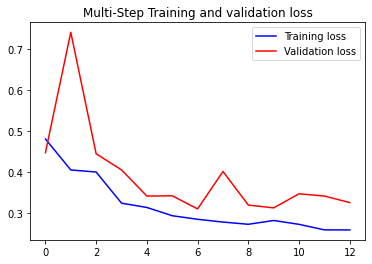

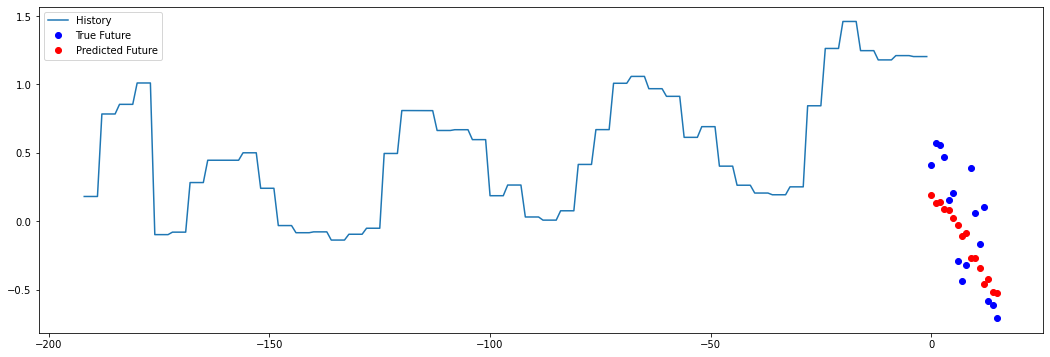

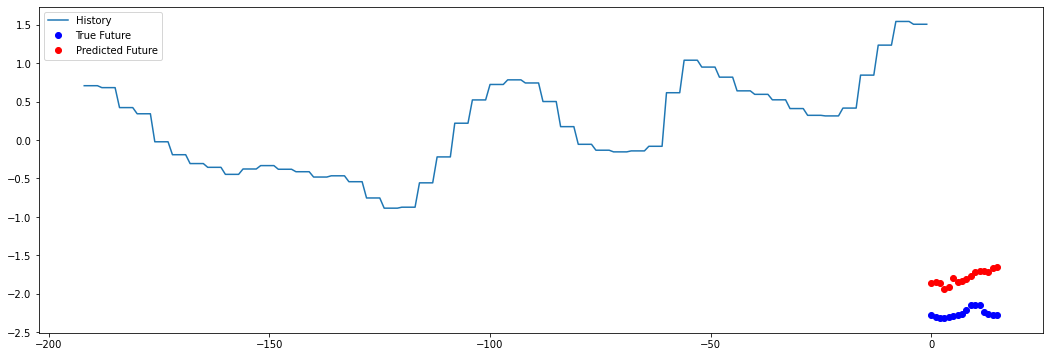

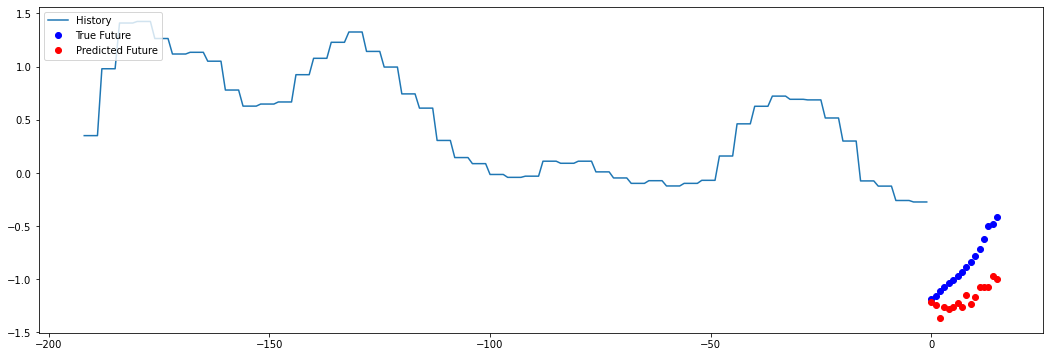

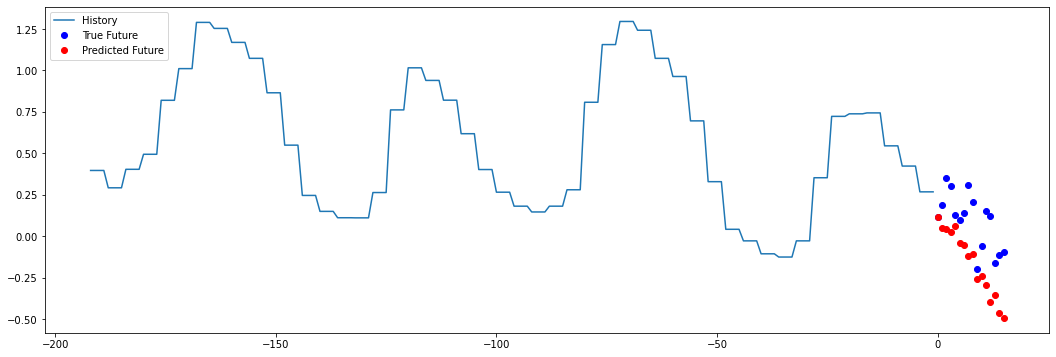

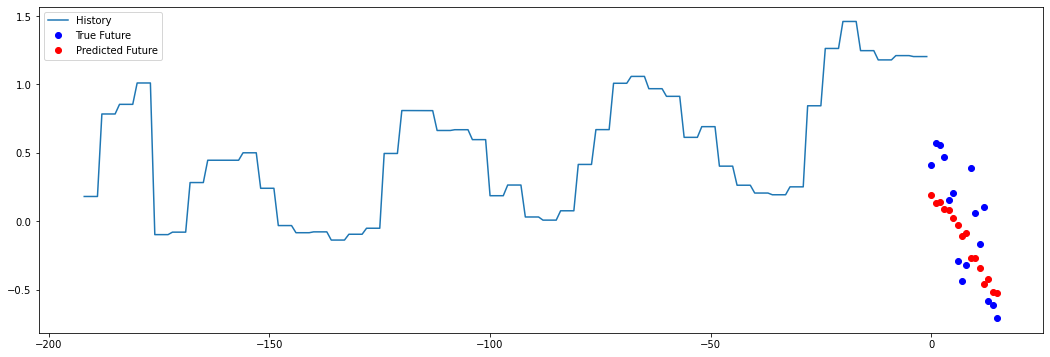

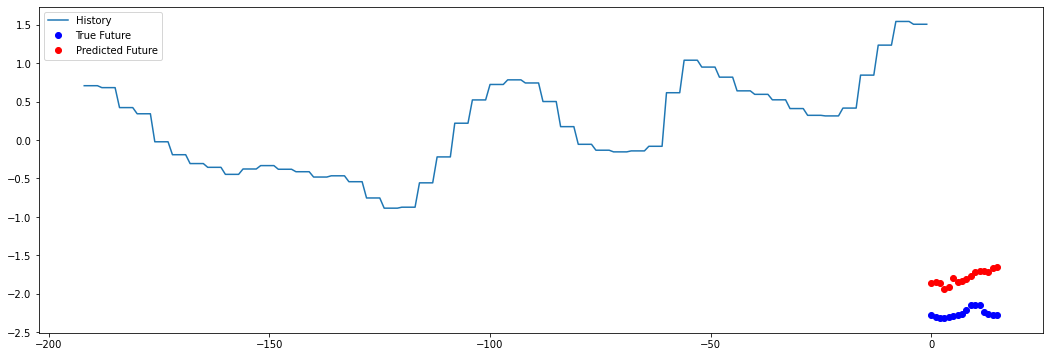

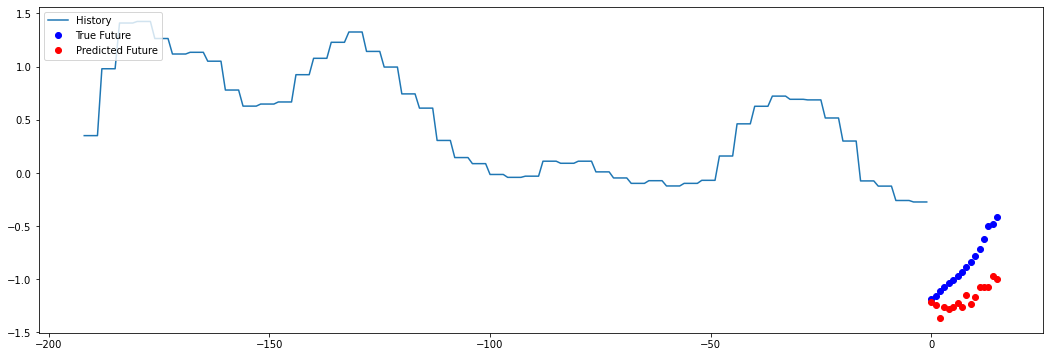

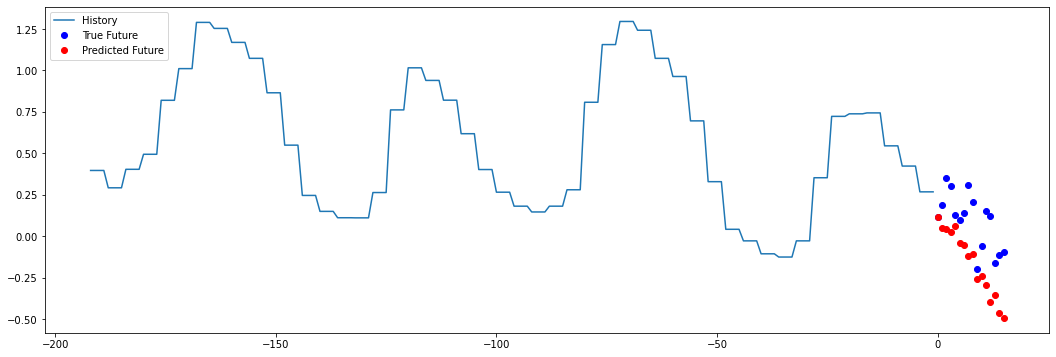

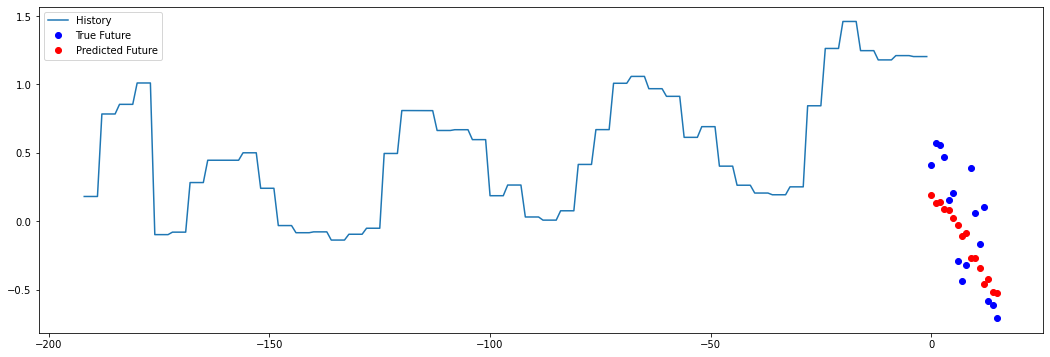

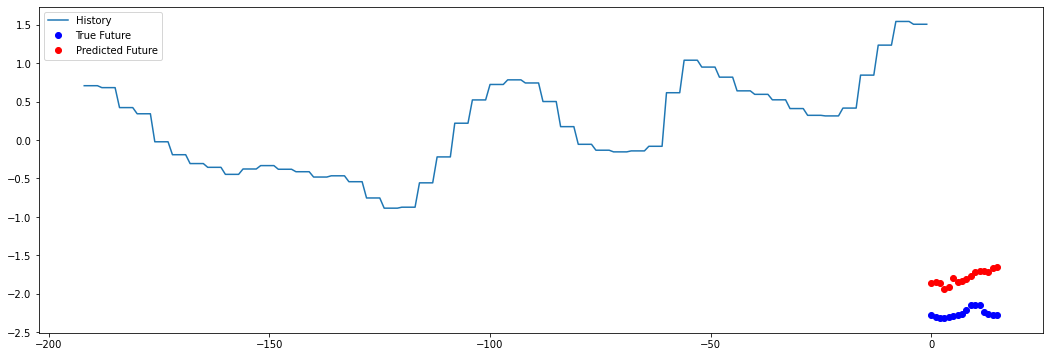

In [8]:
validation_plots(history,10,val_data,model,STEP)

# EncoderDecoder_LSTMCNN

In [9]:
model = build_model_EncoderDecoder_LSTMCNN(n_timesteps,n_features,future_target)

early_stopping = EarlyStopping(monitor='val_loss', patience = 6, restore_best_weights=True)
history = model.fit(
                                train_data,
                                epochs=EPOCHS,
                                steps_per_epoch=EVALUATION_INTERVAL,
                                validation_data=val_data,
                                validation_steps=EVALUATION_INTERVAL,
                                callbacks=[early_stopping]
                                )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 190, 64)           1984      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 188, 64)           12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 94, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 6016)              0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 16, 6016)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16, 200)           4973600   
_________________________________________________________________
time_distributed (TimeDistri (None, 16, 100)           2

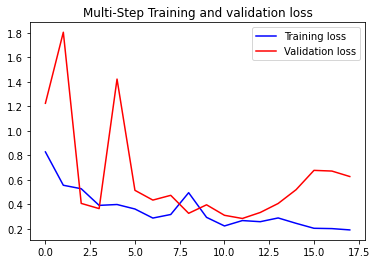

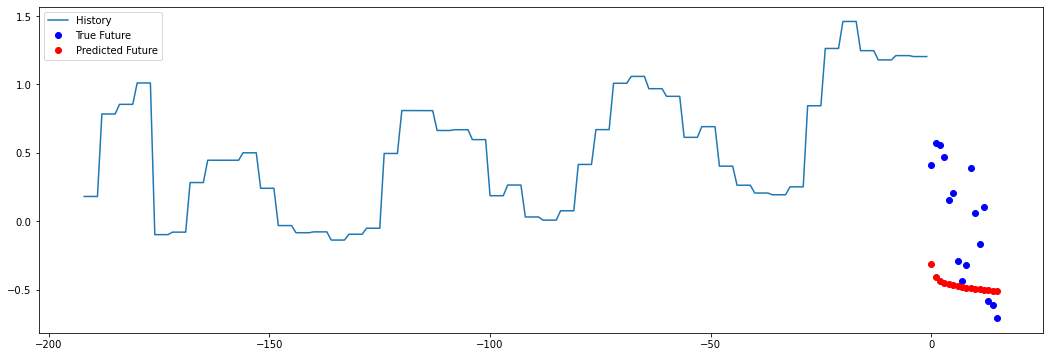

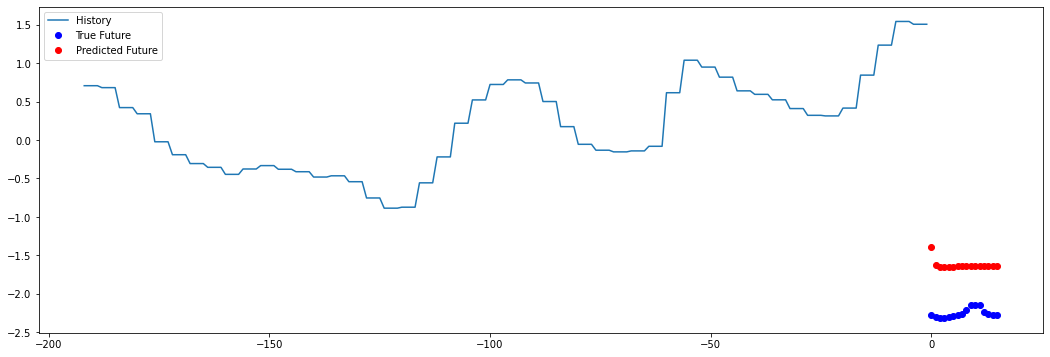

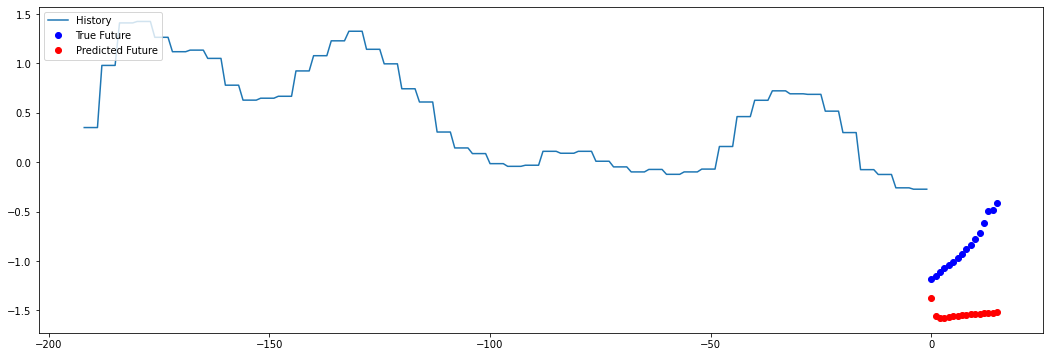

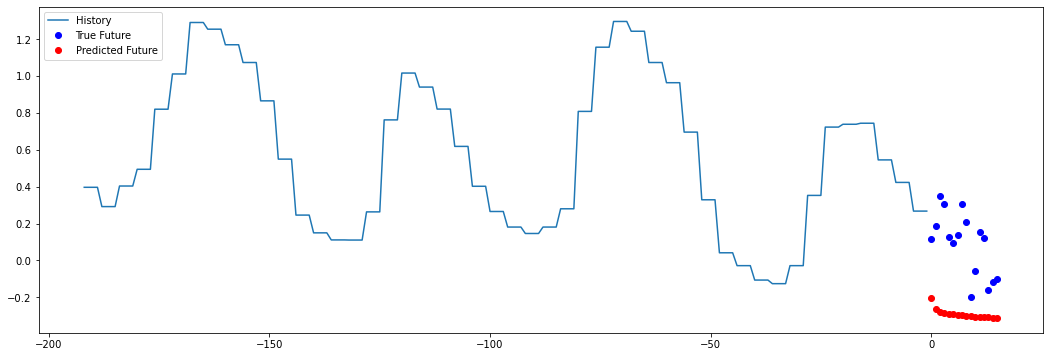

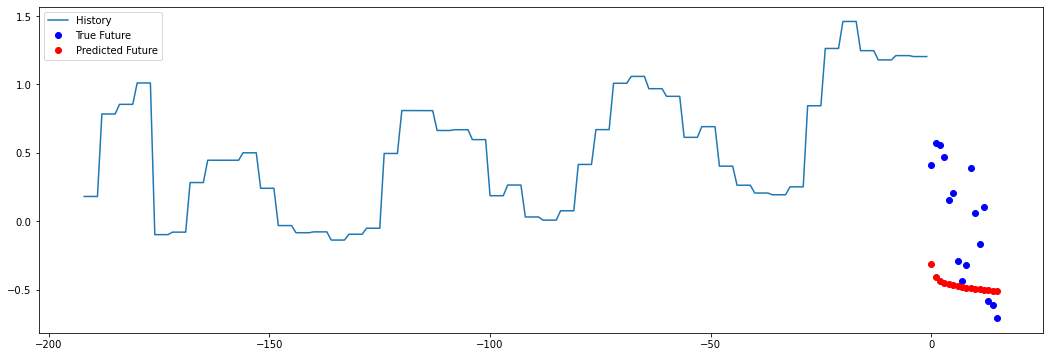

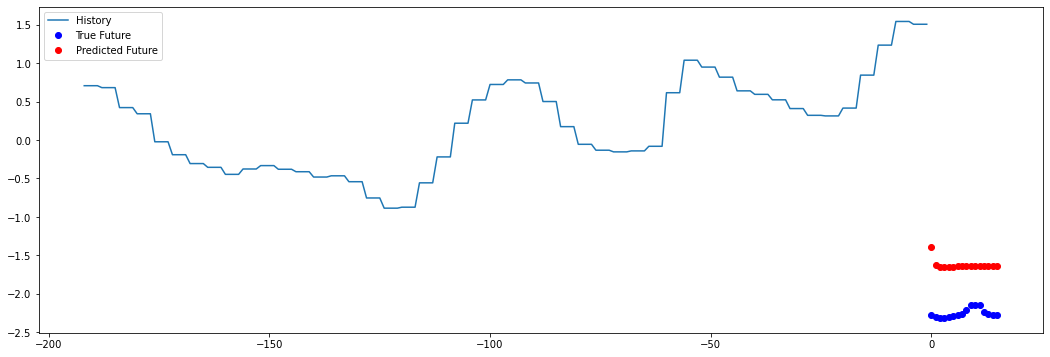

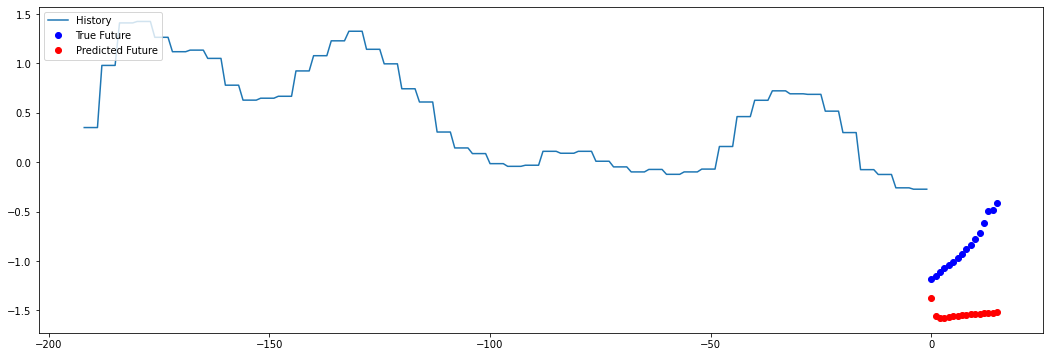

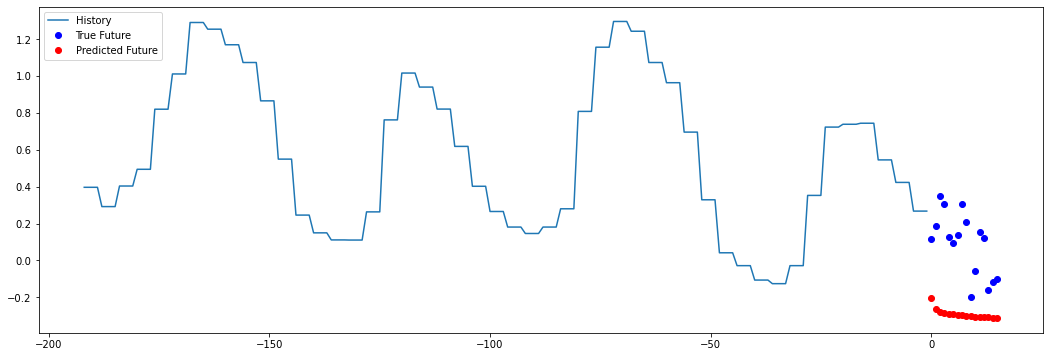

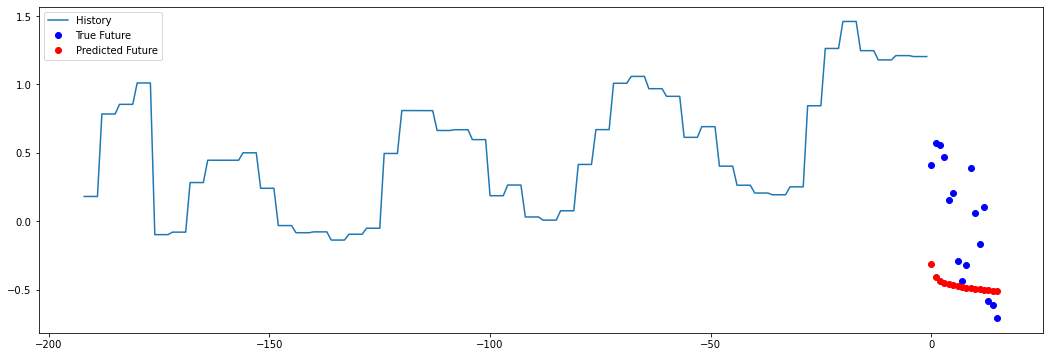

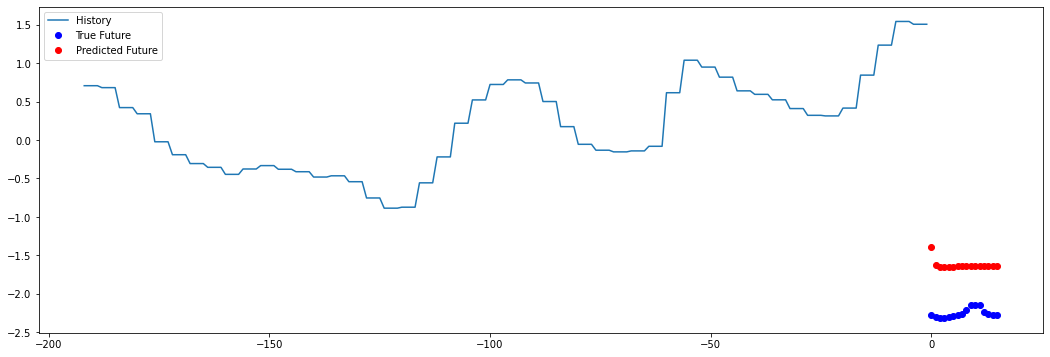

In [10]:
validation_plots(history,10,val_data,model,STEP)

# EncoderDecoderLSTM

In [11]:
model = build_model_EncoderDecoderLSTM(n_timesteps,n_features,future_target)

early_stopping = EarlyStopping(monitor='val_loss', patience = 6, restore_best_weights=True)
history = model.fit(
                                train_data,
                                epochs=EPOCHS,
                                steps_per_epoch=EVALUATION_INTERVAL,
                                validation_data=val_data,
                                validation_steps=EVALUATION_INTERVAL,
                                callbacks=[early_stopping]
                                )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 200)               168800    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 16, 200)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 16, 200)           320800    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 100)           20100     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 1)             101       
Total params: 509,801
Trainable params: 509,801
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
100/100 [==============================] - 9s 92ms/step - loss: 0.3714 - val_loss: 0.5021
Epoch 2

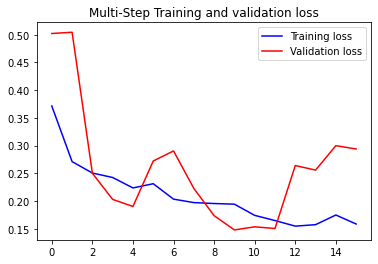

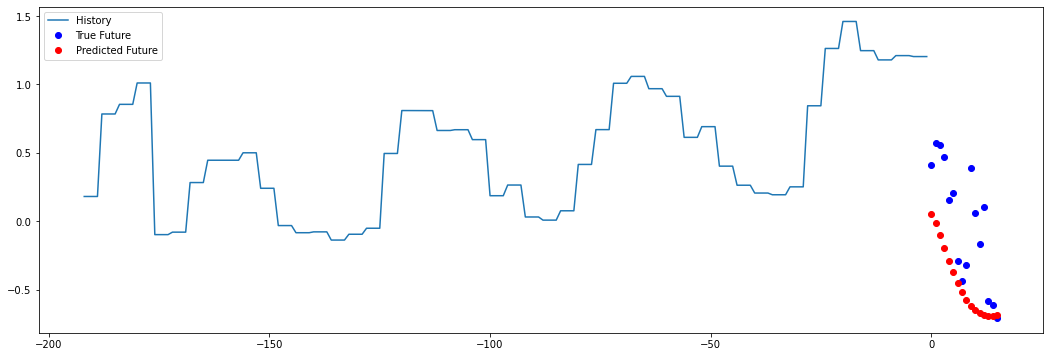

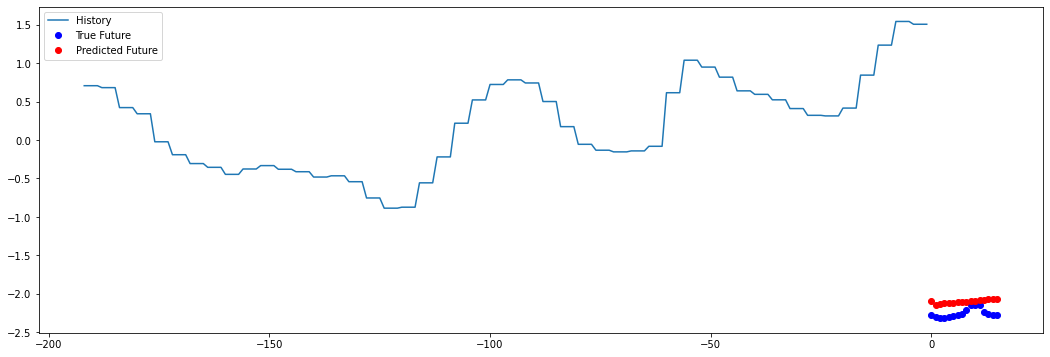

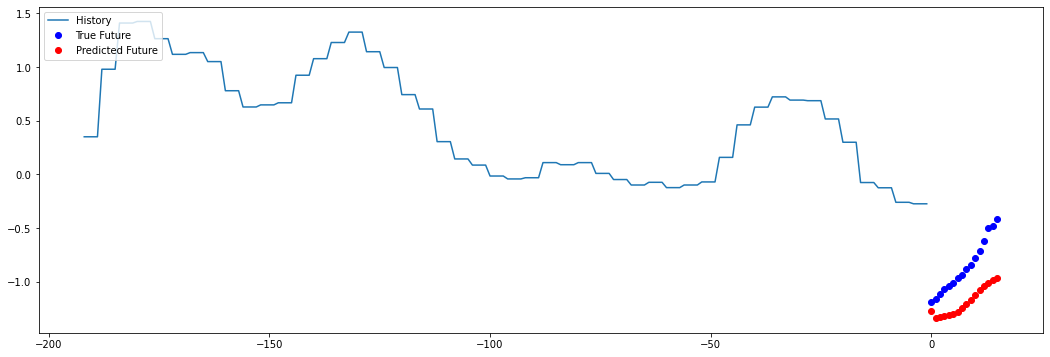

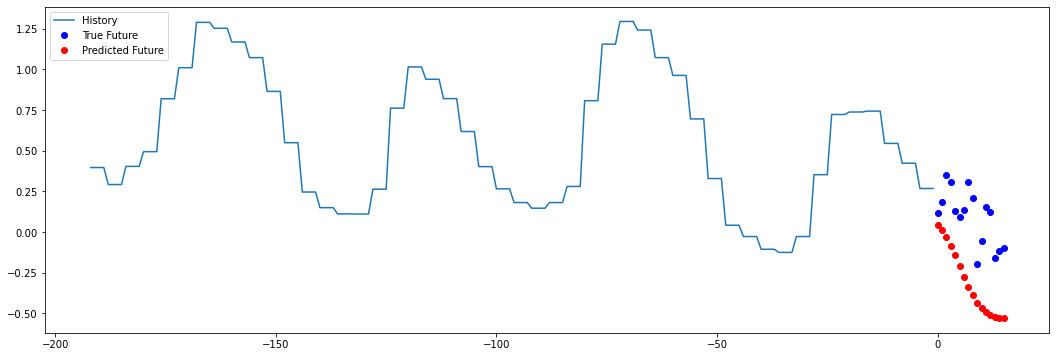

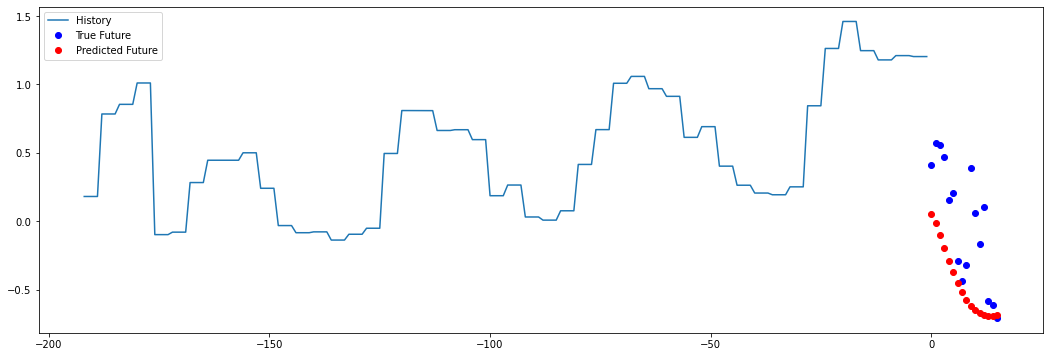

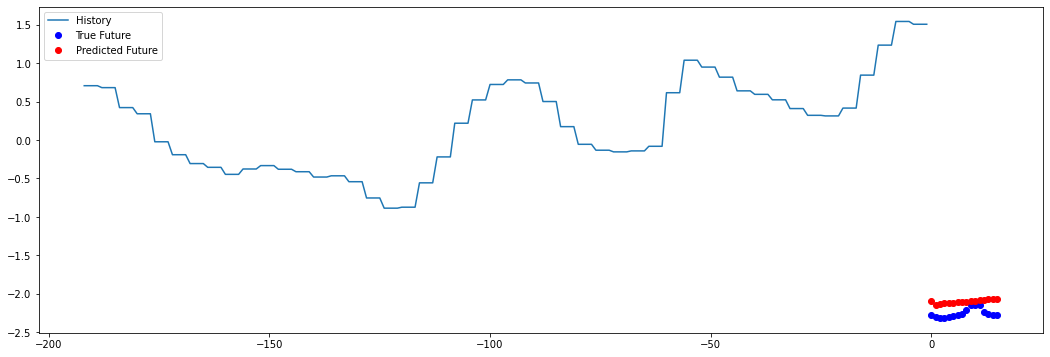

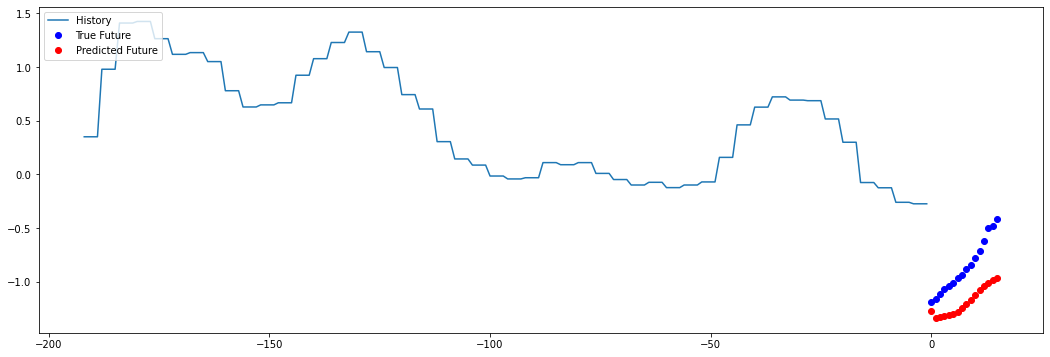

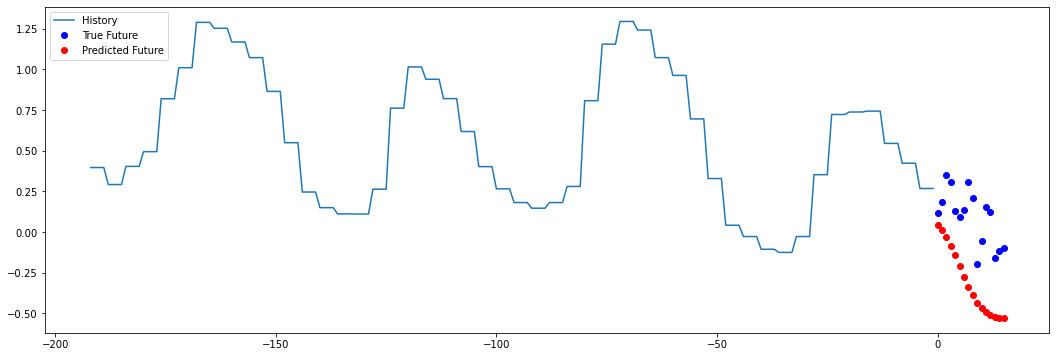

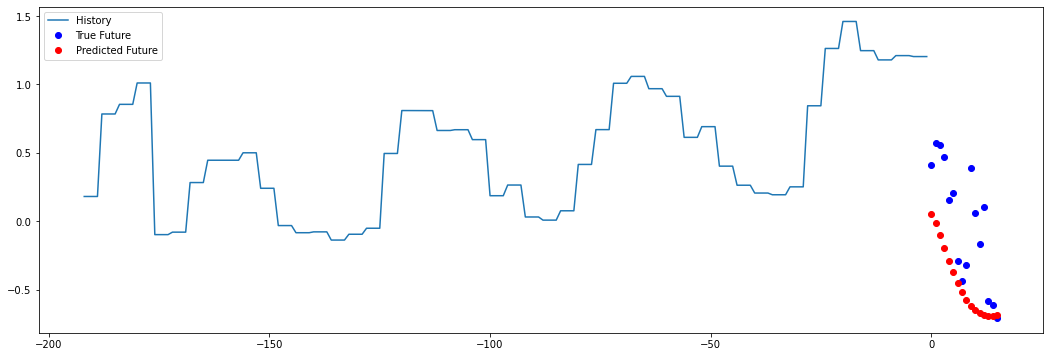

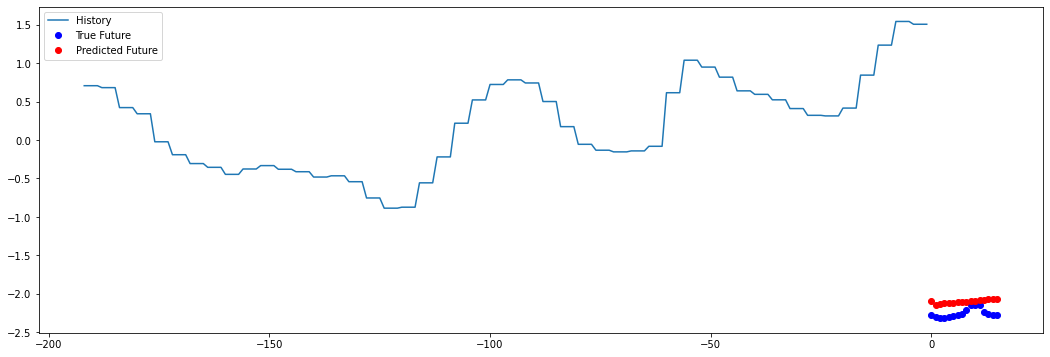

In [12]:
validation_plots(history,10,val_data,model,STEP)

# BasicLSTM_TwoDense

In [13]:
model = build_model_BasicLSTM_TwoDense(n_timesteps,n_features,future_target)

early_stopping = EarlyStopping(monitor='val_loss', patience = 6, restore_best_weights=True)
history = model.fit(
                                train_data,
                                epochs=EPOCHS,
                                steps_per_epoch=EVALUATION_INTERVAL,
                                validation_data=val_data,
                                validation_steps=EVALUATION_INTERVAL,
                                callbacks=[early_stopping]
                                )

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 200)               168800    
_________________________________________________________________
dense_5 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_6 (Dense)              (None, 16)                1616      
Total params: 190,516
Trainable params: 190,516
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
100/100 [==============================] - 8s 79ms/step - loss: 0.4290 - val_loss: 0.3466
Epoch 2/100
100/100 [==============================] - 8s 76ms/step - loss: 0.2472 - val_loss: 0.5480
Epoch 3/100
100/100 [==============================] - 8s 76ms/step - loss: 0.2401 - val_loss: 0.4921
Epoch 4/100
100/100 [==============================] - 8s 76ms/step

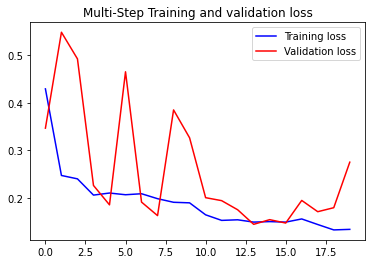

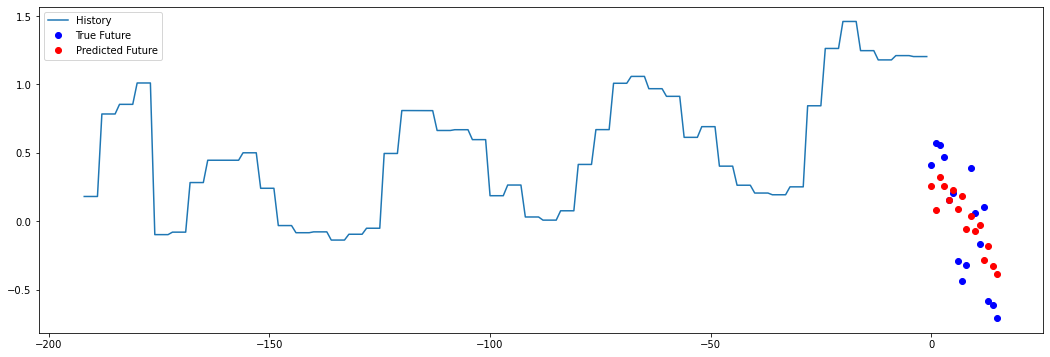

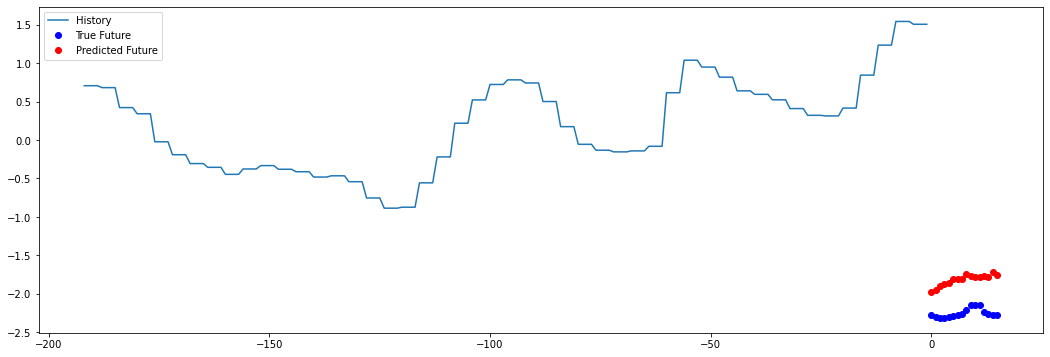

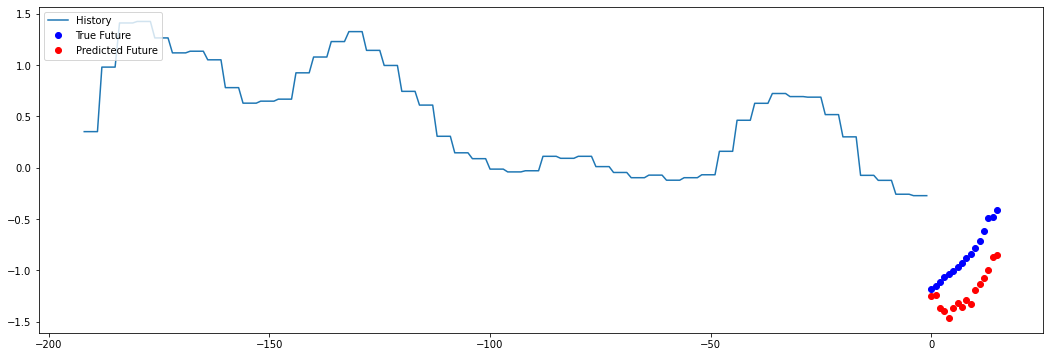

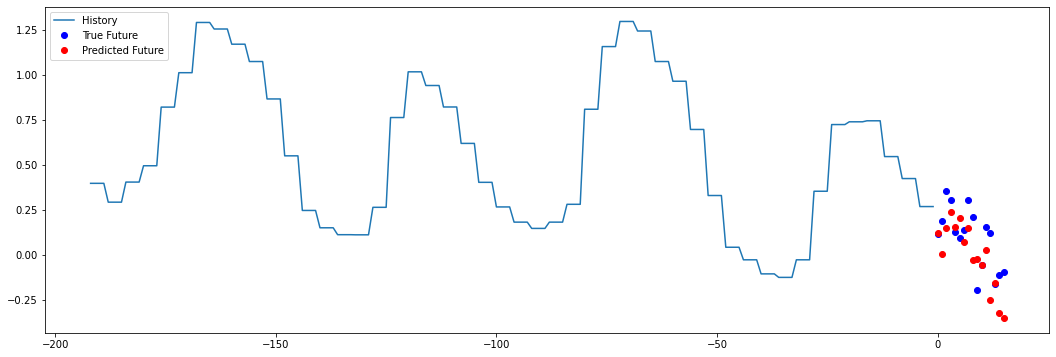

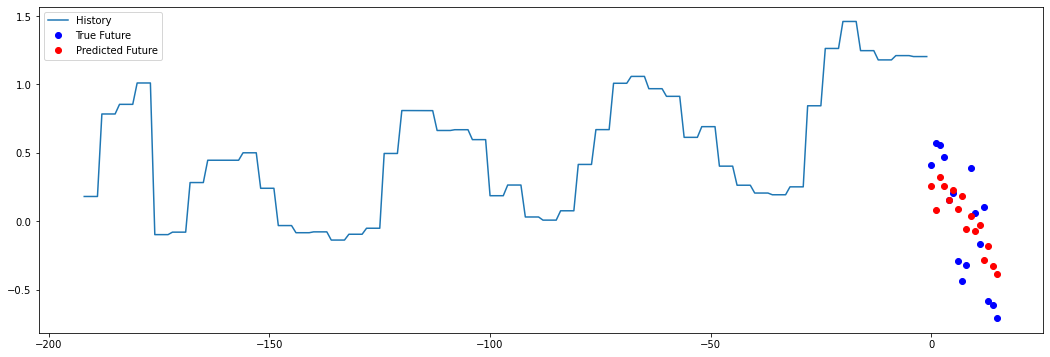

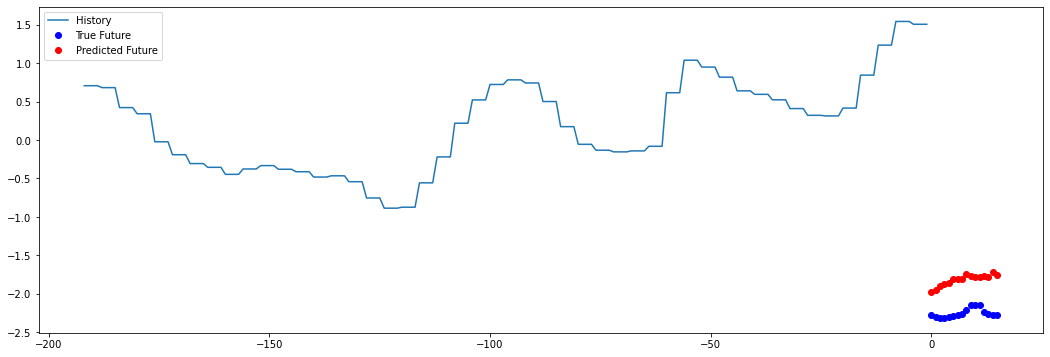

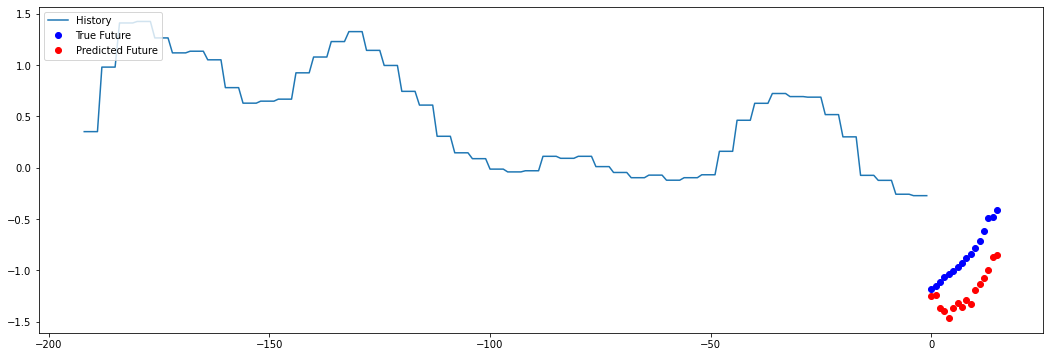

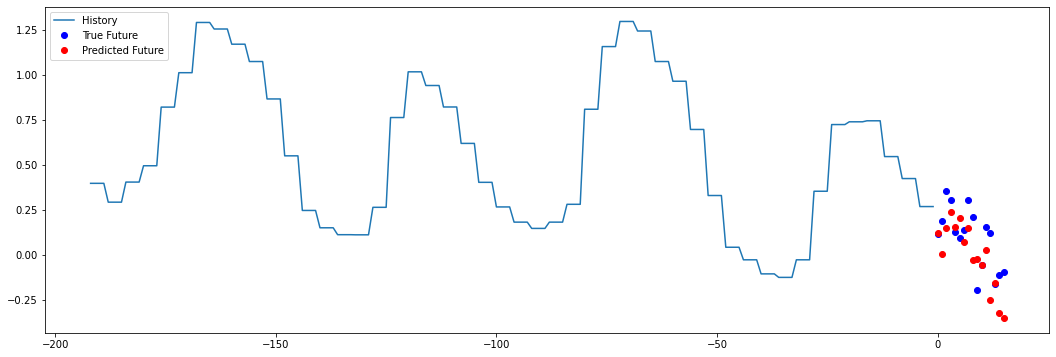

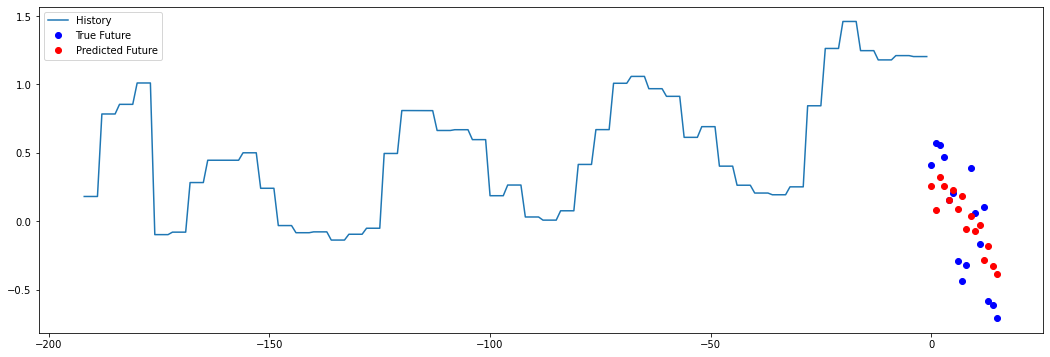

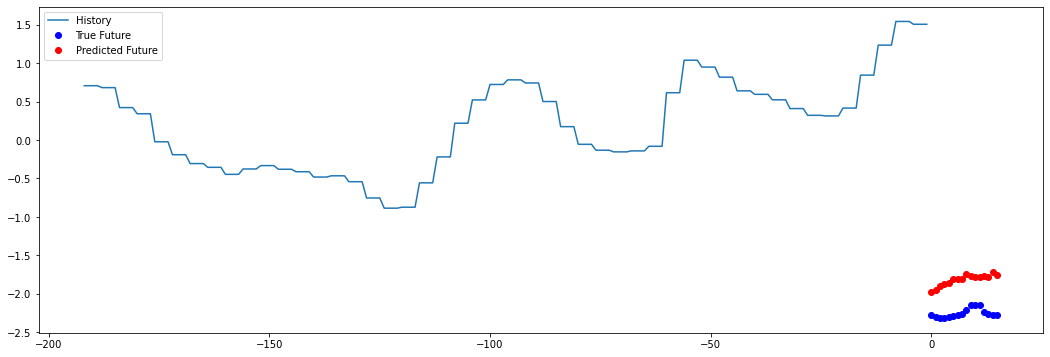

In [14]:
validation_plots(history,10,val_data,model,STEP)

# BasicLSTM_OneLayer

In [15]:
model = build_model_BasicLSTM_OneLayer(n_timesteps,n_features,future_target)

early_stopping = EarlyStopping(monitor='val_loss', patience = 6, restore_best_weights=True)
history = model.fit(
                                train_data,
                                epochs=EPOCHS,
                                steps_per_epoch=EVALUATION_INTERVAL,
                                validation_data=val_data,
                                validation_steps=EVALUATION_INTERVAL,
                                callbacks=[early_stopping]
                                )

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 32)                5504      
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
Total params: 6,032
Trainable params: 6,032
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
100/100 [==============================] - 2s 23ms/step - loss: 0.6564 - val_loss: 0.6427
Epoch 2/100
100/100 [==============================] - 2s 19ms/step - loss: 0.4376 - val_loss: 0.5224
Epoch 3/100
100/100 [==============================] - 2s 19ms/step - loss: 0.3682 - val_loss: 0.4476
Epoch 4/100
100/100 [==============================] - 2s 19ms/step - loss: 0.3281 - val_loss: 0.3888
Epoch 5/100
100/100 [==============================] - 2s 19ms/step - loss: 0.3075 - val_loss: 0.3732

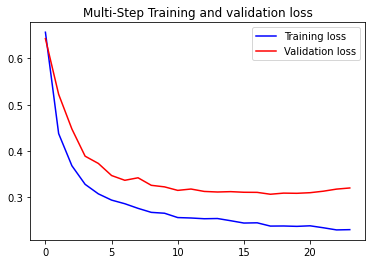

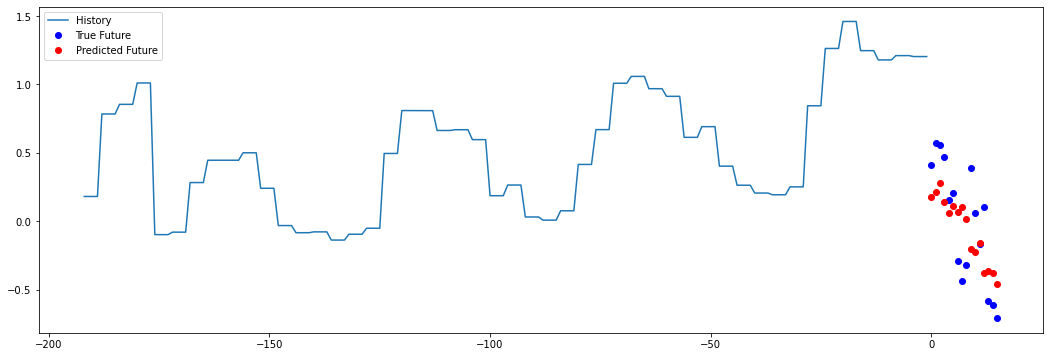

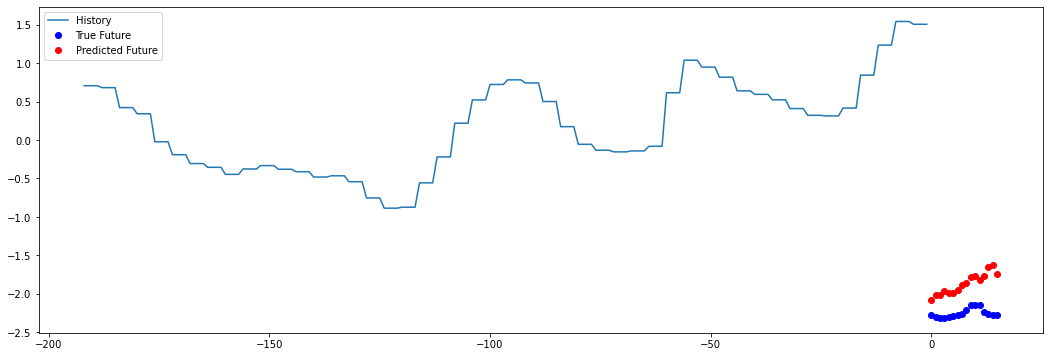

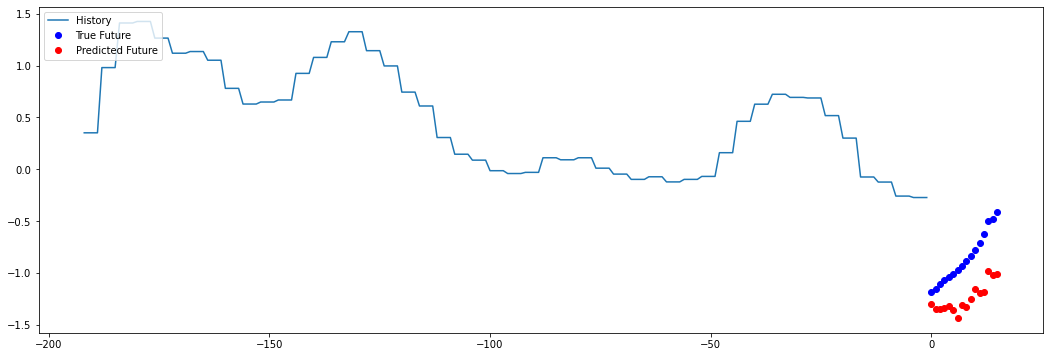

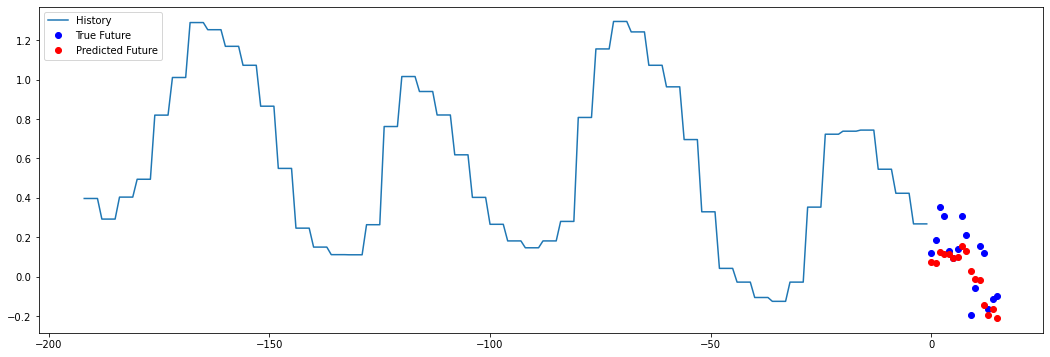

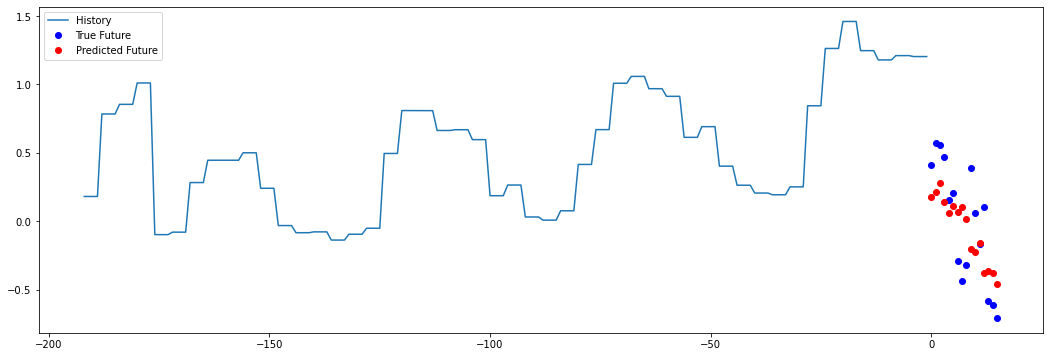

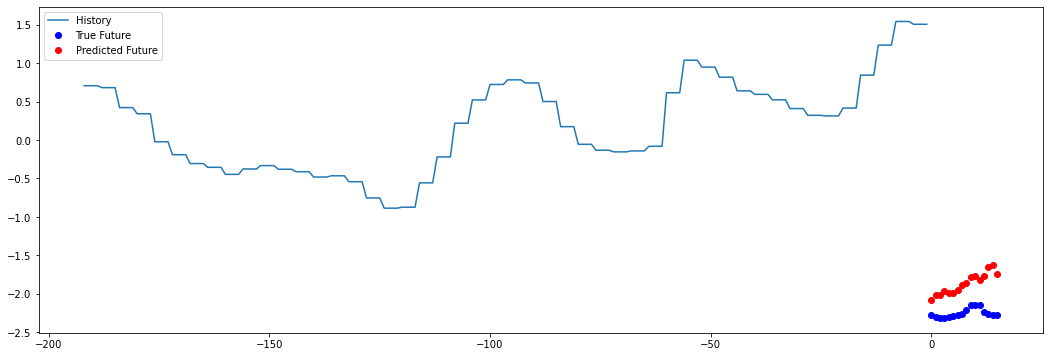

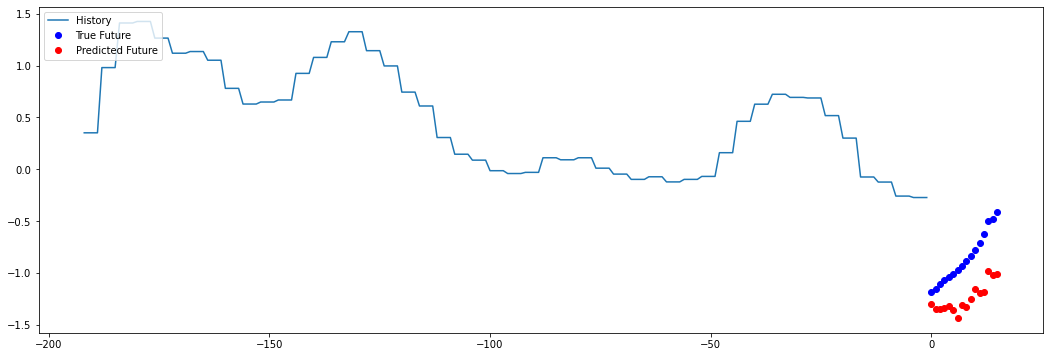

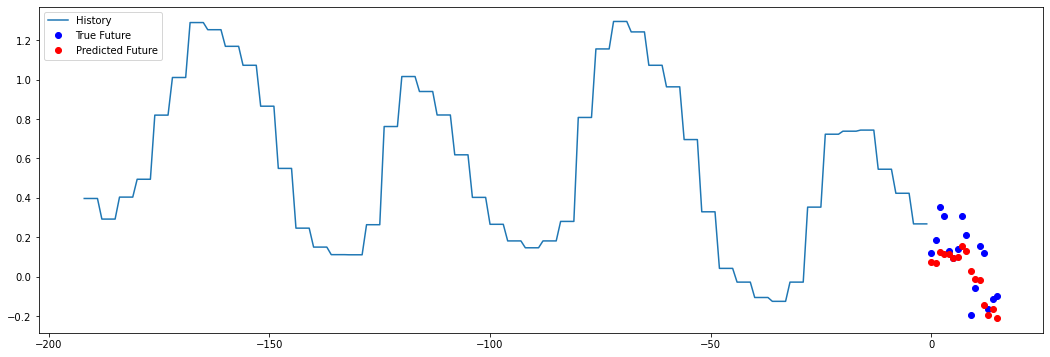

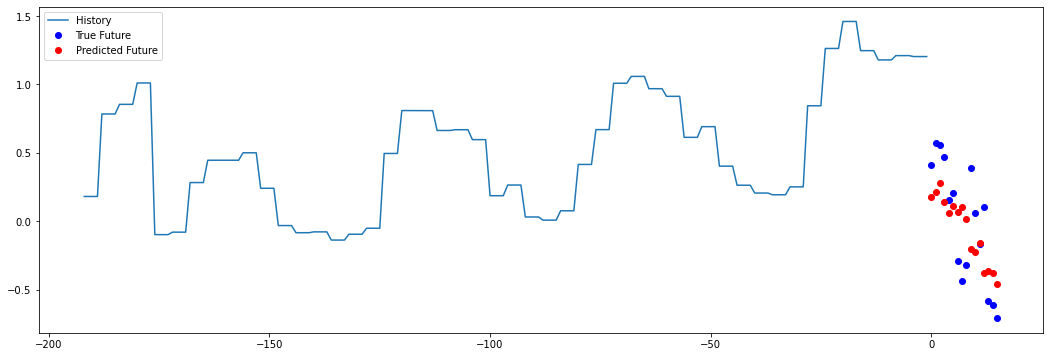

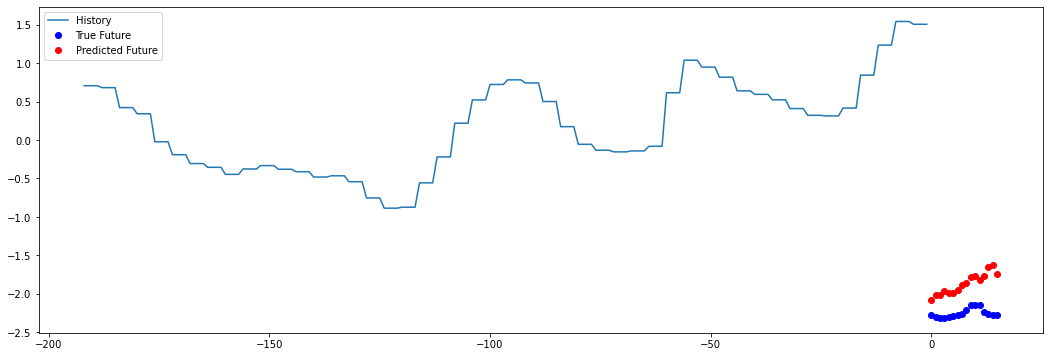

In [16]:
validation_plots(history,10,val_data,model,STEP)

# BasicLSTM

In [17]:
model = build_model_BasicLSTM(n_timesteps,n_features,future_target)

early_stopping = EarlyStopping(monitor='val_loss', patience = 6, restore_best_weights=True)
history = model.fit(
                                train_data,
                                epochs=EPOCHS,
                                steps_per_epoch=EVALUATION_INTERVAL,
                                validation_data=val_data,
                                validation_steps=EVALUATION_INTERVAL,
                                callbacks=[early_stopping]
                                )

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 192, 32)           5504      
_________________________________________________________________
lstm_7 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
Total params: 8,912
Trainable params: 8,912
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
100/100 [==============================] - 3s 34ms/step - loss: 0.6634 - val_loss: 0.7335
Epoch 2/100
100/100 [==============================] - 3s 28ms/step - loss: 0.4668 - val_loss: 0.5496
Epoch 3/100
100/100 [==============================] - 3s 28ms/step - loss: 0.3812 - val_loss: 0.4429
Epoch 4/100
100/100 [==============================] - 3s 28ms/step - l

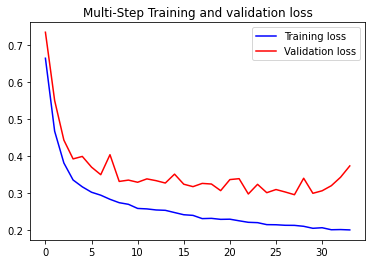

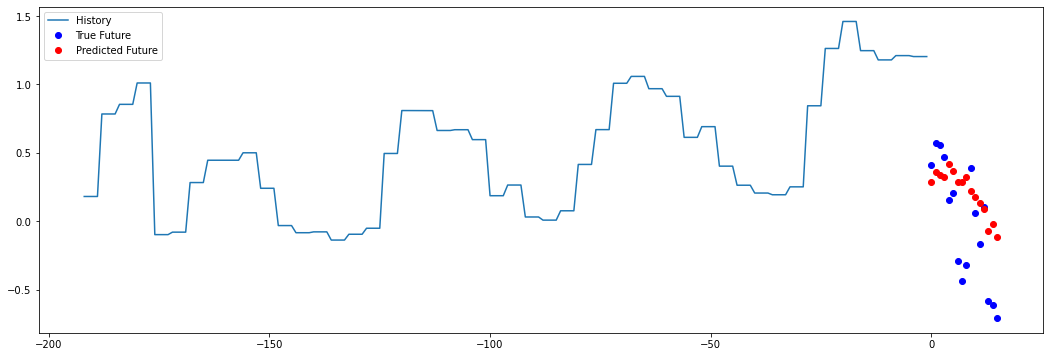

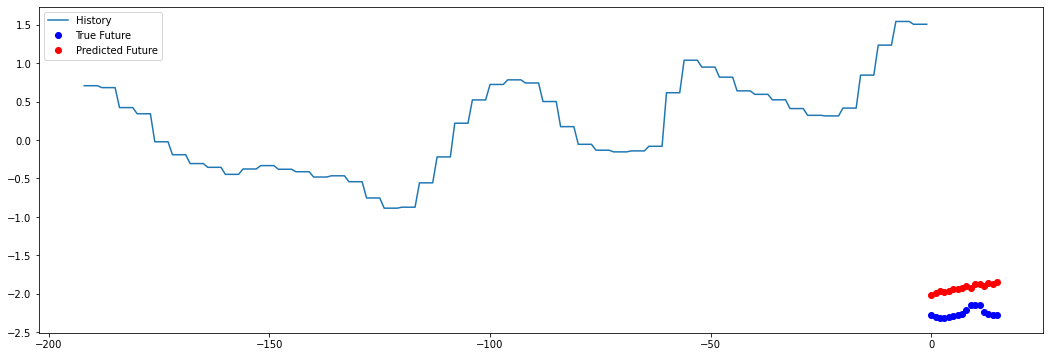

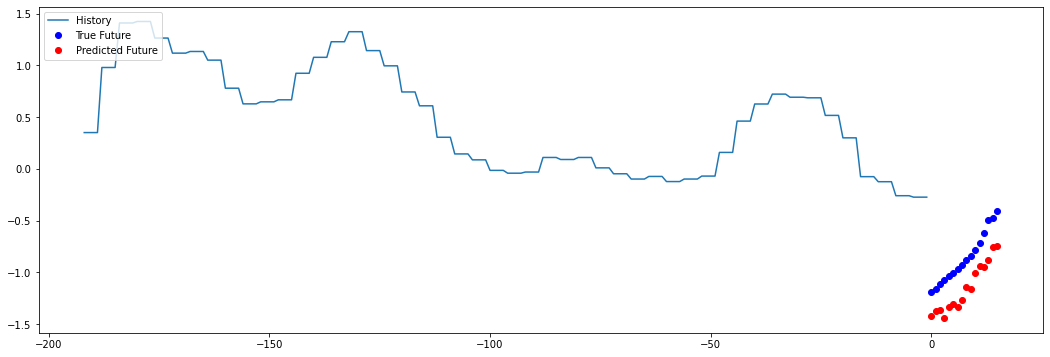

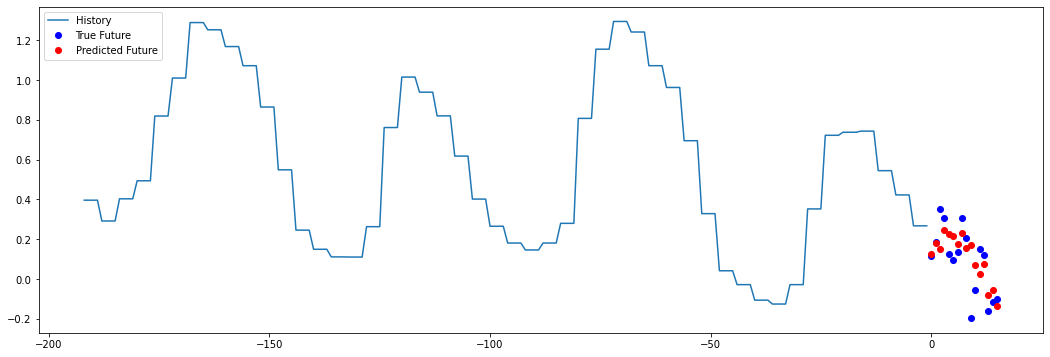

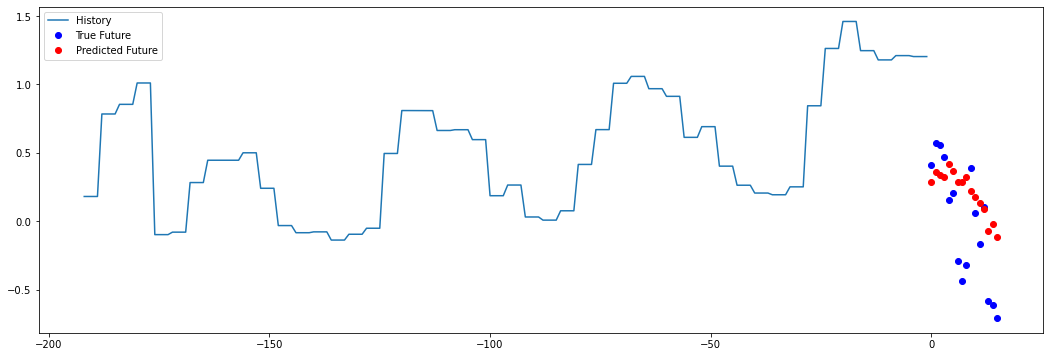

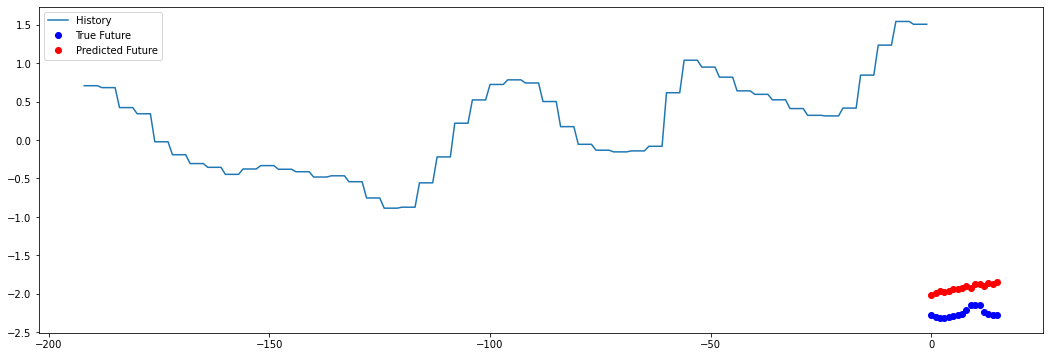

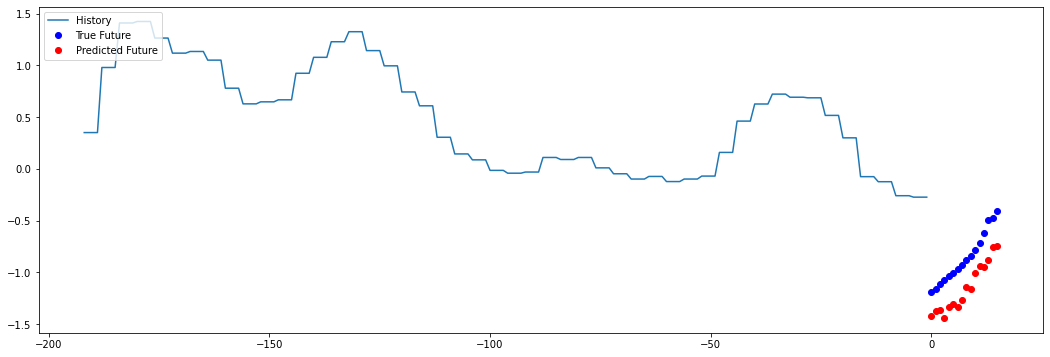

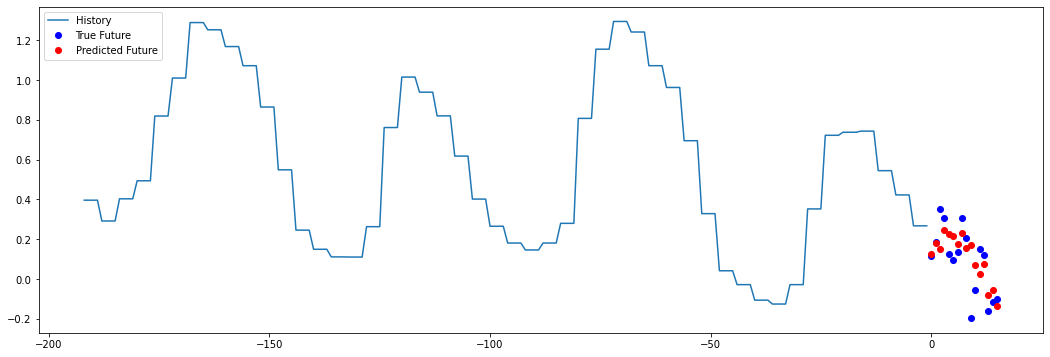

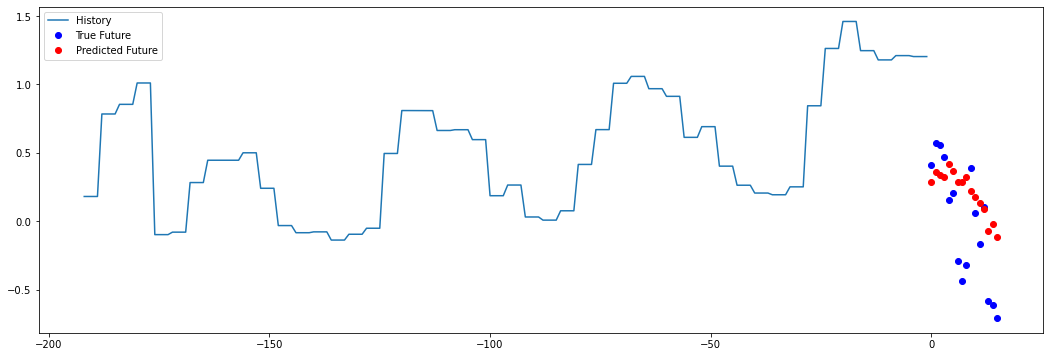

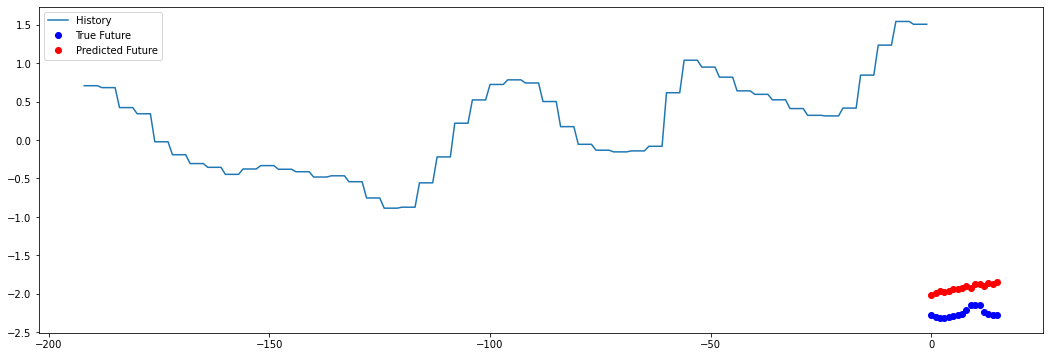

In [18]:
validation_plots(history,10,val_data,model,STEP)

# BidirectionalLSTM Params

In [21]:
past_history = 16 # 2days
future_target = 16 # 4hours
STEP = 1
TRAIN_SPLIT = 18000
BUFFER_SIZE = 2000
BATCH_SIZE = 512
EPOCHS = 100
EVALUATION_INTERVAL = 100
train_data, val_data, x_train, y_train = preprocess_data_for_LSTM(
    df[:20000], 
    features, 
    past_history,
    future_target,
    STEP,
    TRAIN_SPLIT,
    BATCH_SIZE,
    BUFFER_SIZE)
n_timesteps = x_train.shape[-2:][0]
n_features = x_train.shape[-2:][1]

(17984, 16, 10)
(17984, 16)
Single window of past history : (16, 10)
Target usage to predict : (16,)


# BidirectionalLSTM SUM

In [22]:
model = build_model_BidirectionalLSTM(n_timesteps,n_features,future_target,"sum")

early_stopping = EarlyStopping(monitor='val_loss', patience = 6, restore_best_weights=True)
history = model.fit(
                                train_data,
                                epochs=EPOCHS,
                                steps_per_epoch=EVALUATION_INTERVAL,
                                validation_data=val_data,
                                validation_steps=EVALUATION_INTERVAL,
                                callbacks=[early_stopping]
                                )

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 16, 20)            4960      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 16, 1)             21        
Total params: 4,981
Trainable params: 4,981
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
100/100 [==============================] - 2s 17ms/step - loss: 0.8351 - accuracy: 0.0000e+00 - val_loss: 0.5152 - val_accuracy: 0.0000e+00
Epoch 2/100
100/100 [==============================] - 1s 6ms/step - loss: 0.3527 - accuracy: 0.0000e+00 - val_loss: 0.4030 - val_accuracy: 0.0000e+00
Epoch 3/100
100/100 [==============================] - 1s 6ms/step - loss: 0.2683 - accuracy: 0.0000e+00 - val_loss: 0.3741 - val_accuracy: 0.0000e+00
Epoch 4/100
100/100 [==============================] - 

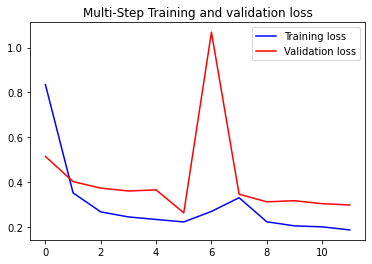

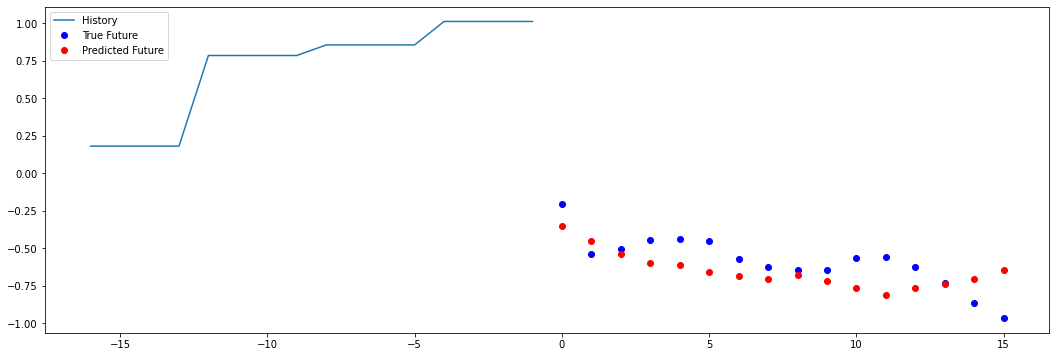

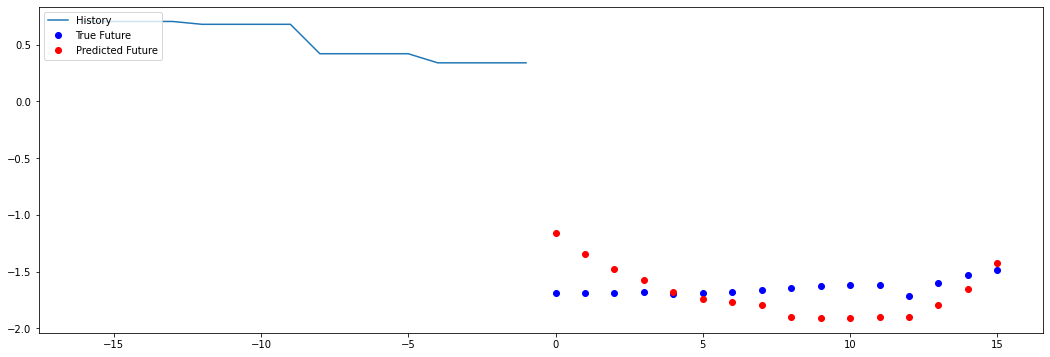

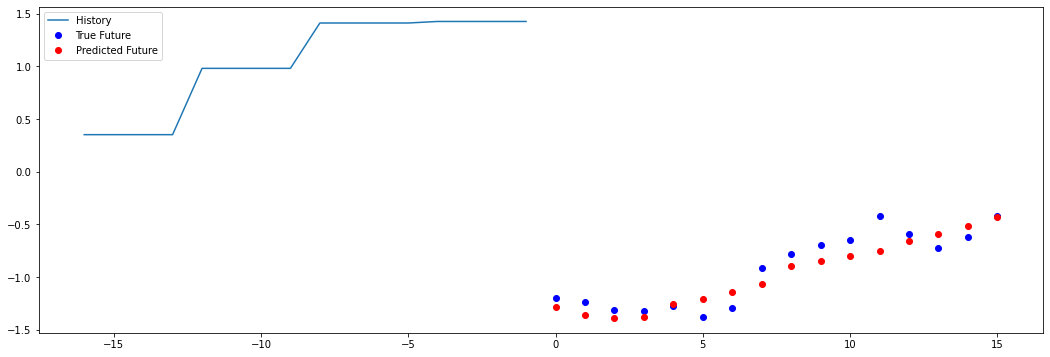

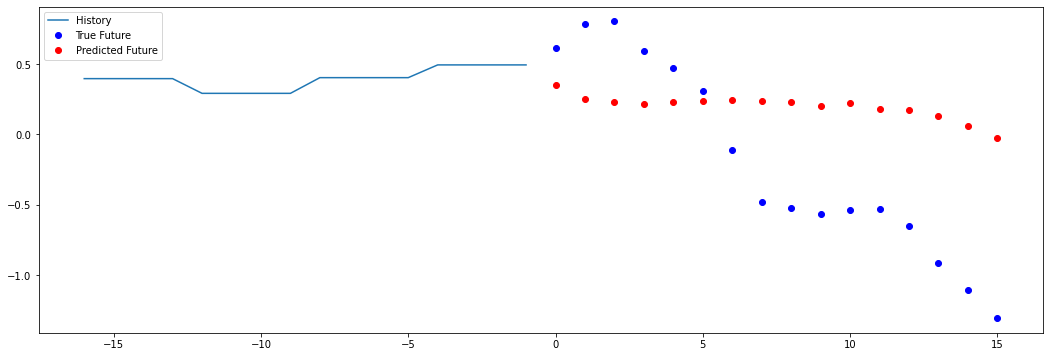

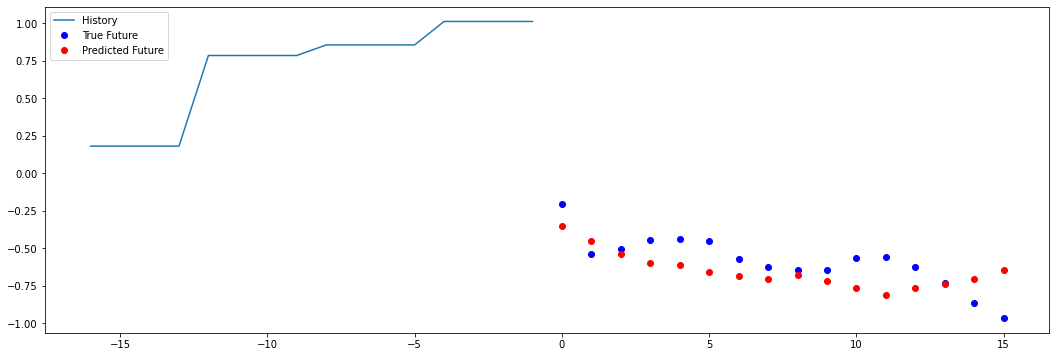

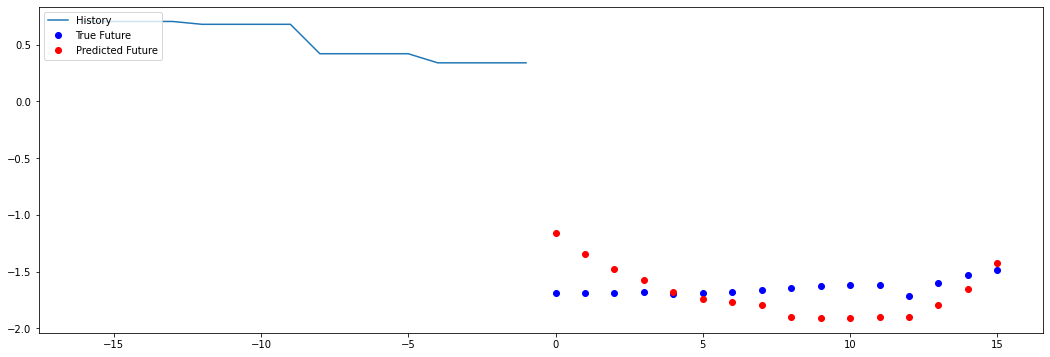

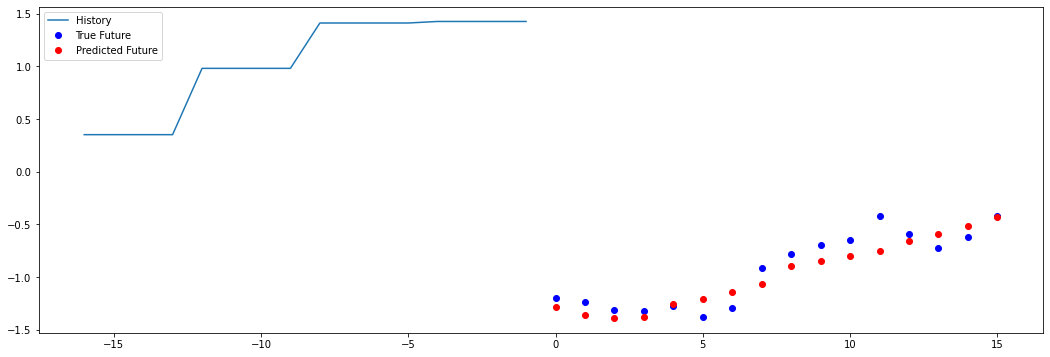

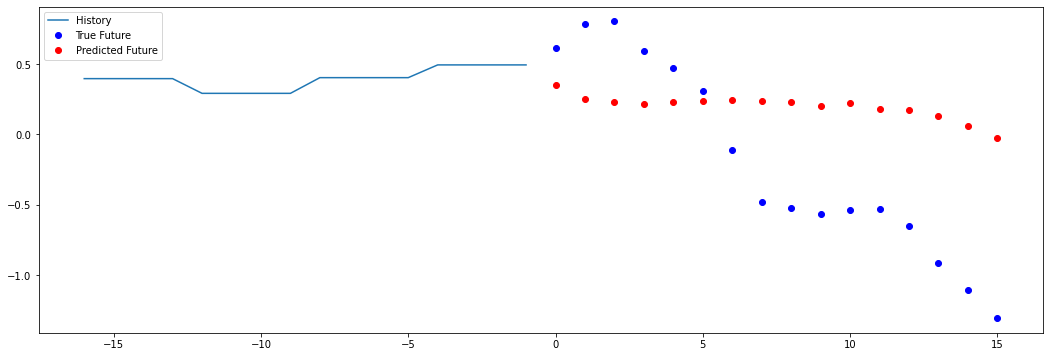

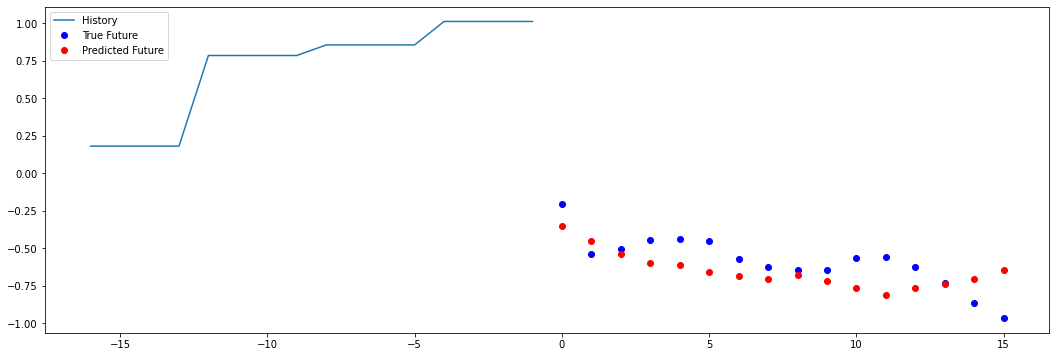

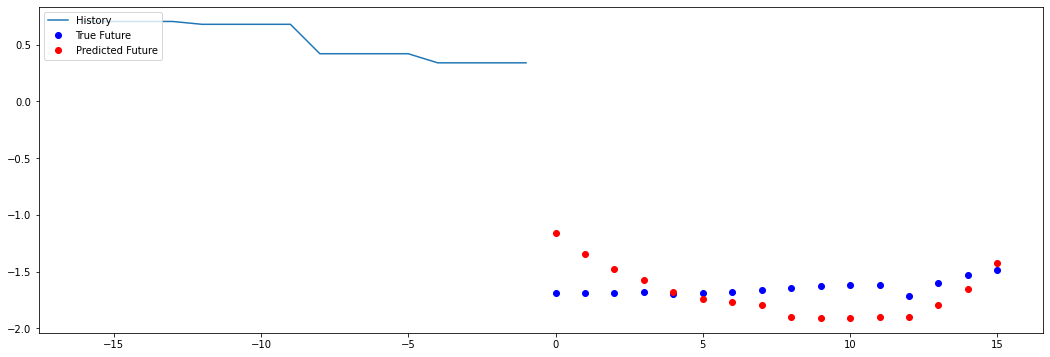

In [23]:
validation_plots(history,10,val_data,model,STEP)

# BidirectionalLSTM MUL

In [24]:
model = build_model_BidirectionalLSTM(n_timesteps,n_features,future_target,"mul")

early_stopping = EarlyStopping(monitor='val_loss', patience = 6, restore_best_weights=True)
history = model.fit(
                                train_data,
                                epochs=EPOCHS,
                                steps_per_epoch=EVALUATION_INTERVAL,
                                validation_data=val_data,
                                validation_steps=EVALUATION_INTERVAL,
                                callbacks=[early_stopping]
                                )

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 16, 20)            4960      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 16, 1)             21        
Total params: 4,981
Trainable params: 4,981
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
100/100 [==============================] - 1s 13ms/step - loss: 0.9572 - accuracy: 0.0000e+00 - val_loss: 1.6598 - val_accuracy: 0.0000e+00
Epoch 2/100
100/100 [==============================] - 1s 7ms/step - loss: 0.7344 - accuracy: 0.0000e+00 - val_loss: 1.2431 - val_accuracy: 0.0000e+00
Epoch 3/100
100/100 [==============================] - 1s 6ms/step - loss: 0.4432 - accuracy: 0.0000e+00 - val_loss: 0.7888 - val_accuracy: 0.0000e+00
Epoch 4/100
100/100 [==============================] - 

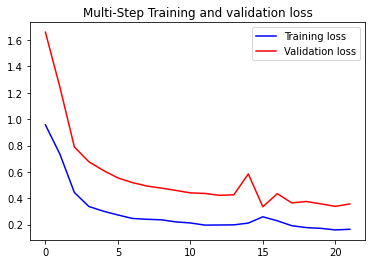

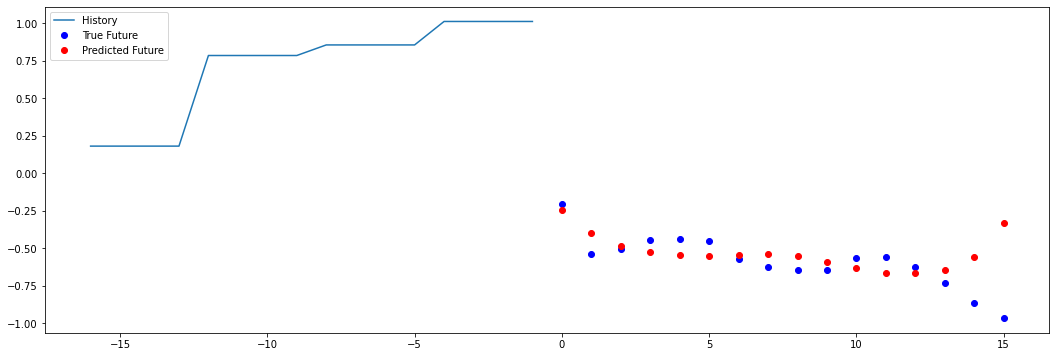

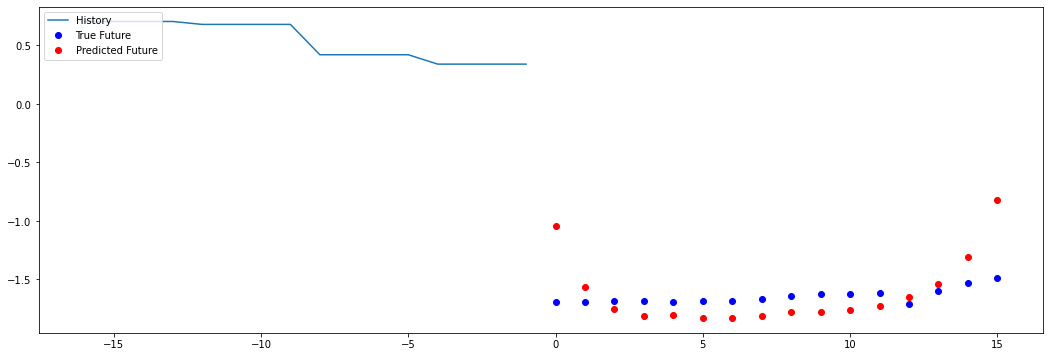

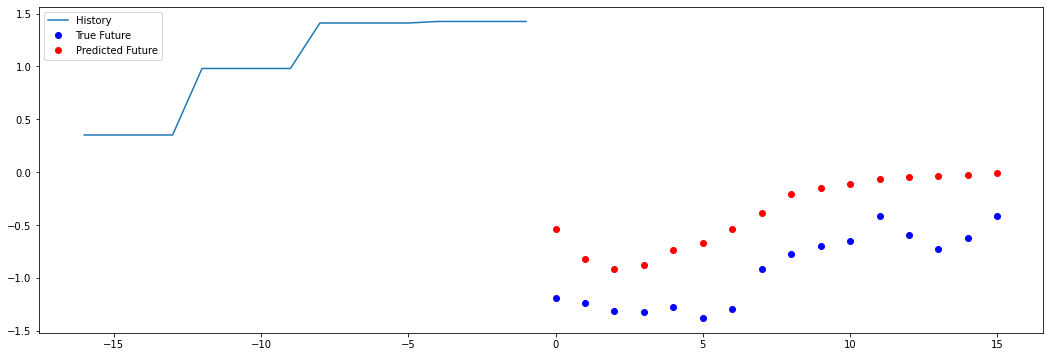

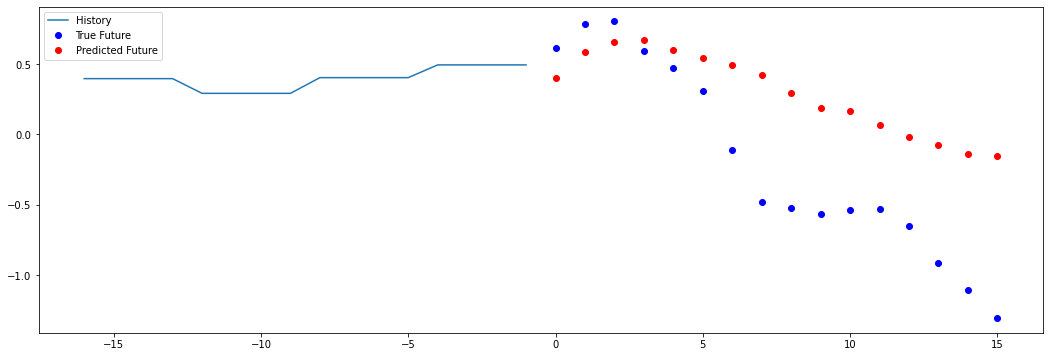

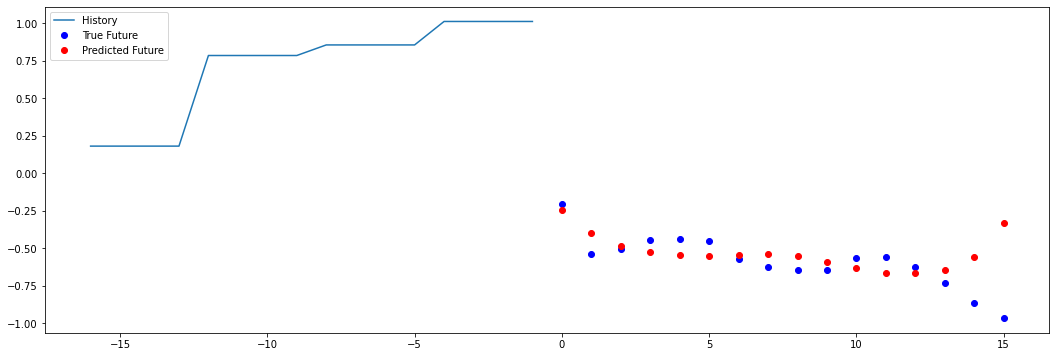

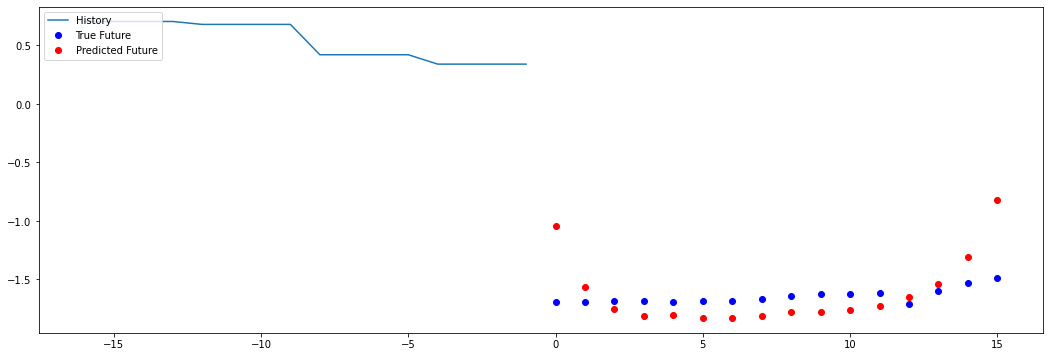

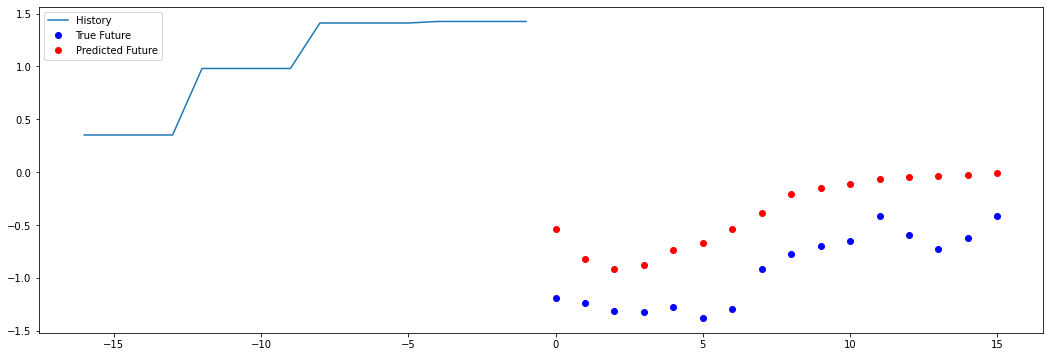

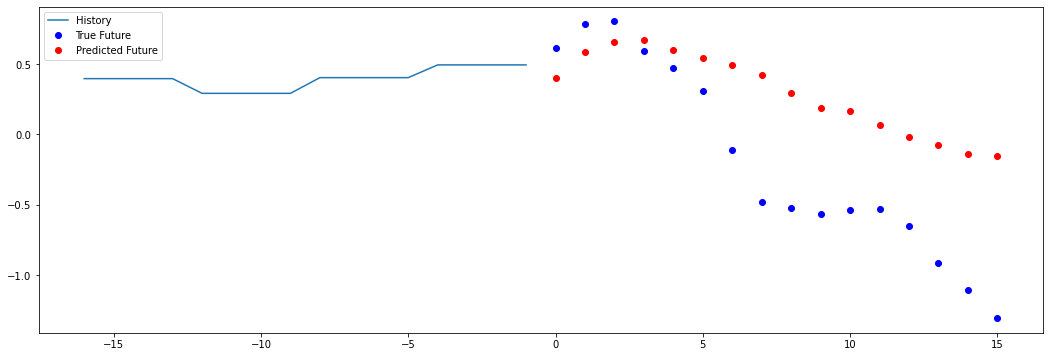

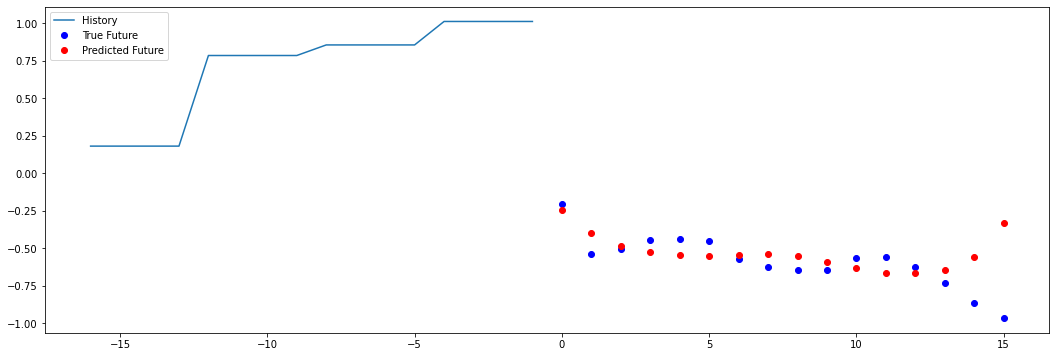

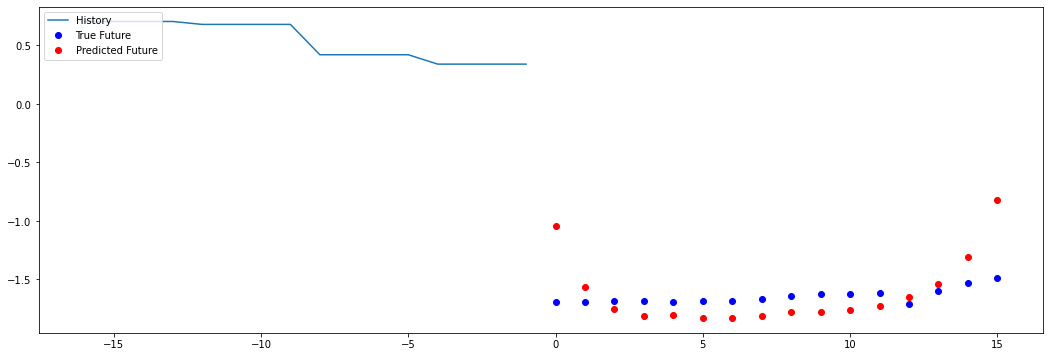

In [25]:
validation_plots(history,10,val_data,model,STEP)

# BidirectionalLSTM ave

In [26]:
model = build_model_BidirectionalLSTM(n_timesteps,n_features,future_target,"ave")

early_stopping = EarlyStopping(monitor='val_loss', patience = 6, restore_best_weights=True)
history = model.fit(
                                train_data,
                                epochs=EPOCHS,
                                steps_per_epoch=EVALUATION_INTERVAL,
                                validation_data=val_data,
                                validation_steps=EVALUATION_INTERVAL,
                                callbacks=[early_stopping]
                                )

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 16, 20)            4960      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 16, 1)             21        
Total params: 4,981
Trainable params: 4,981
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
100/100 [==============================] - 1s 13ms/step - loss: 0.8296 - accuracy: 0.0000e+00 - val_loss: 1.1307 - val_accuracy: 0.0000e+00
Epoch 2/100
100/100 [==============================] - 1s 6ms/step - loss: 0.4634 - accuracy: 0.0000e+00 - val_loss: 0.6087 - val_accuracy: 0.0000e+00
Epoch 3/100
100/100 [==============================] - 1s 7ms/step - loss: 0.3164 - accuracy: 0.0000e+00 - val_loss: 0.4938 - val_accuracy: 0.0000e+00
Epoch 4/100
100/100 [==============================] - 

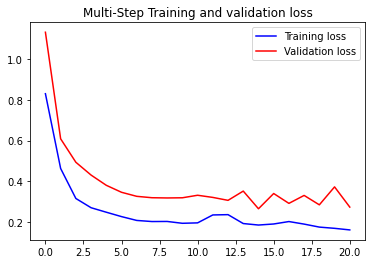

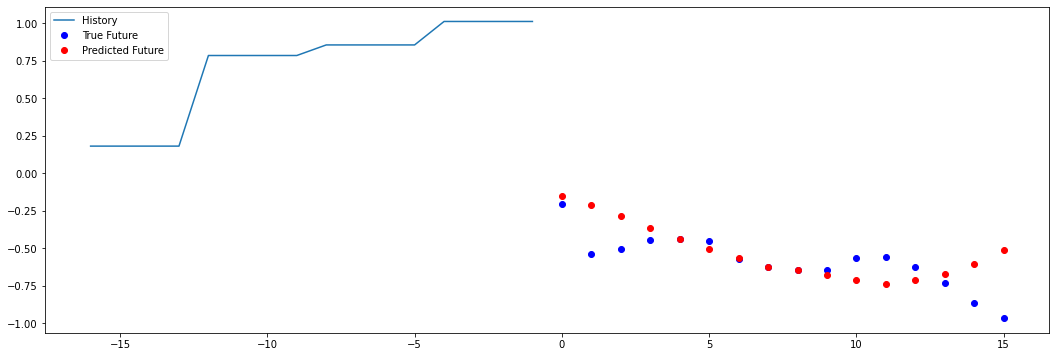

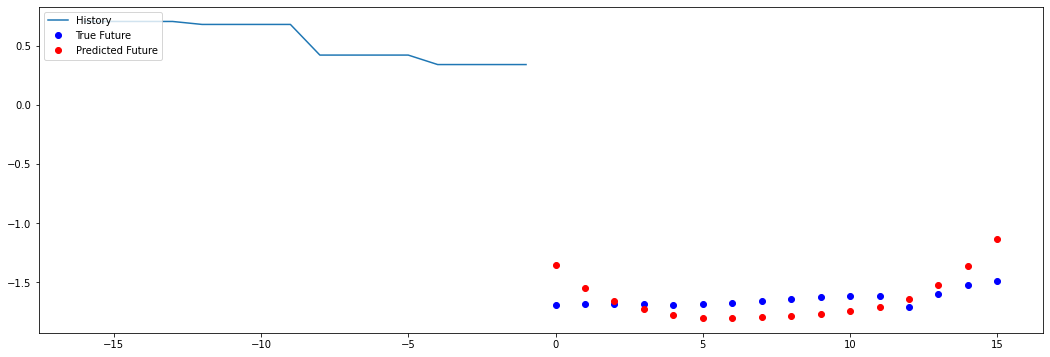

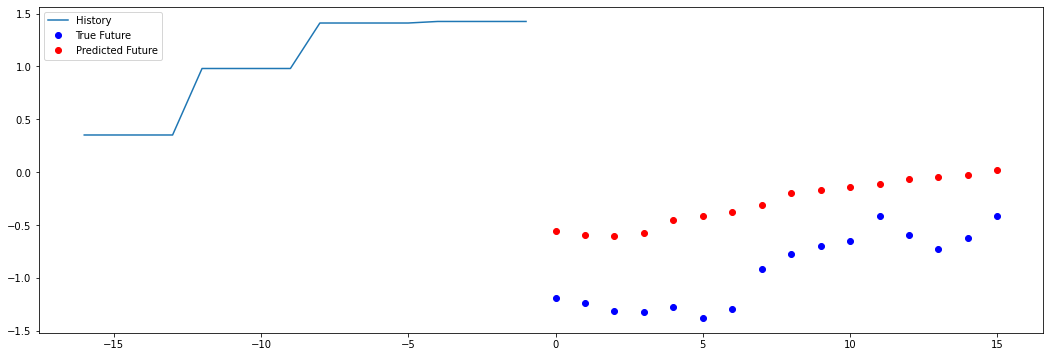

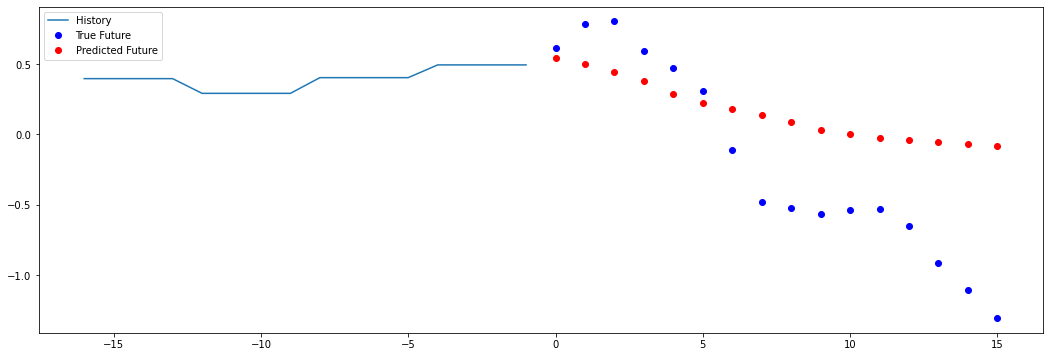

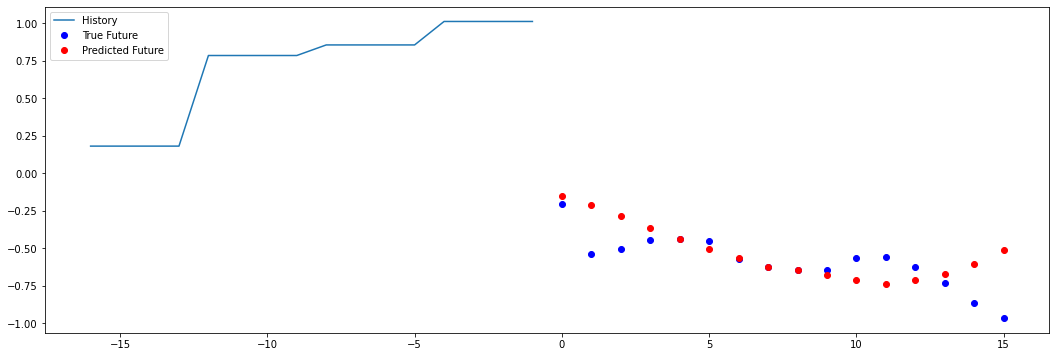

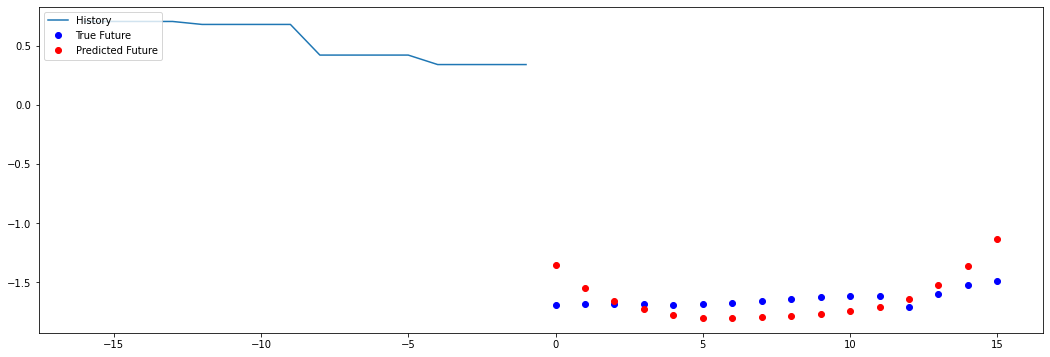

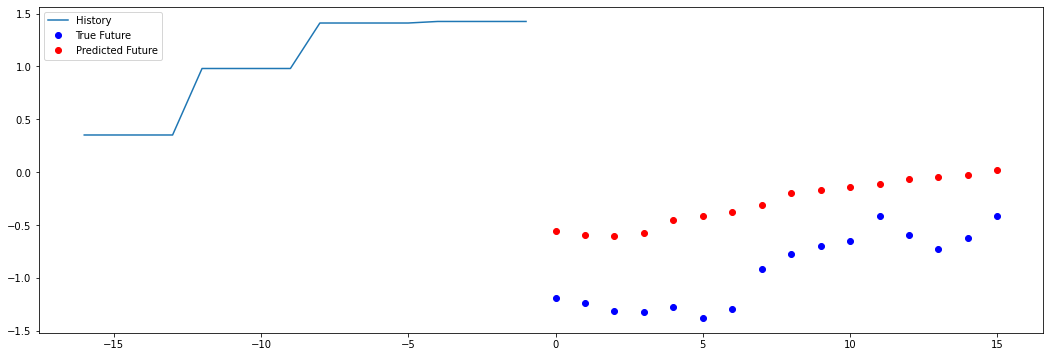

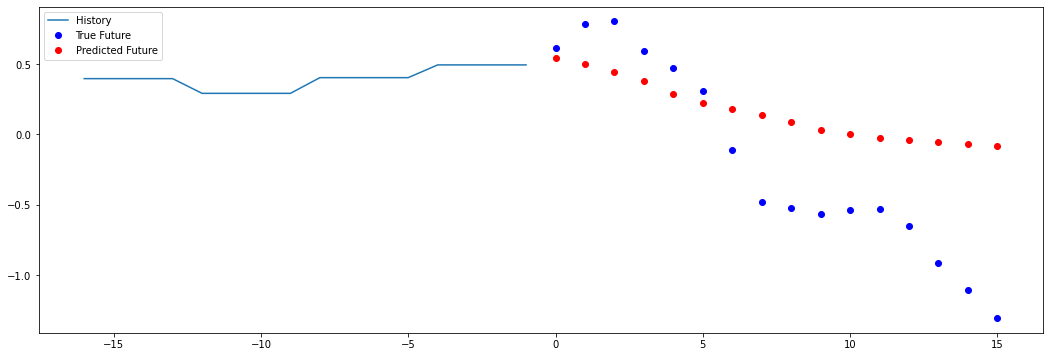

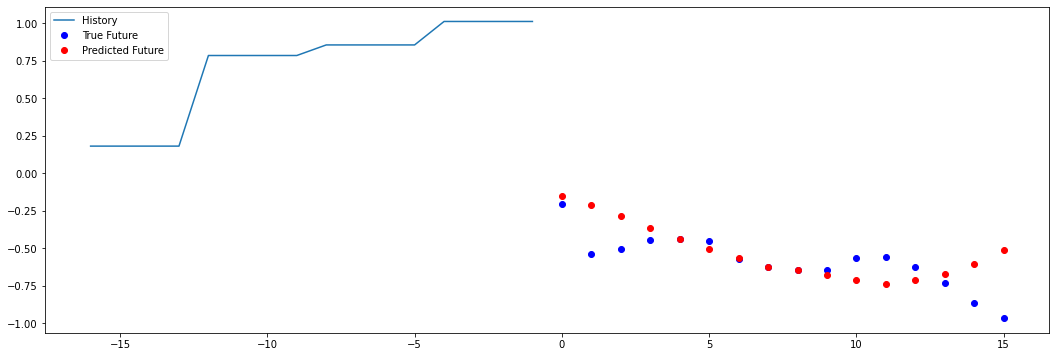

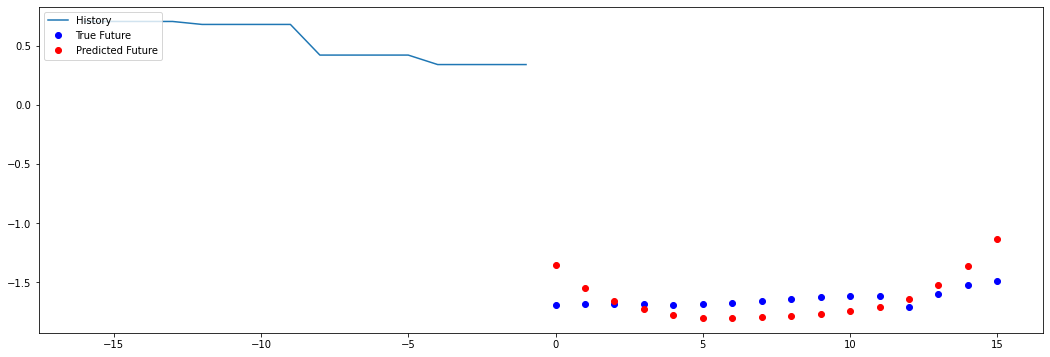

In [27]:
validation_plots(history,10,val_data,model,STEP)

# BidirectionalLSTM concat

In [28]:
model = build_model_BidirectionalLSTM(n_timesteps,n_features,future_target,"concat")

early_stopping = EarlyStopping(monitor='val_loss', patience = 6, restore_best_weights=True)
history = model.fit(
                                train_data,
                                epochs=EPOCHS,
                                steps_per_epoch=EVALUATION_INTERVAL,
                                validation_data=val_data,
                                validation_steps=EVALUATION_INTERVAL,
                                callbacks=[early_stopping]
                                )

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 16, 40)            4960      
_________________________________________________________________
time_distributed_8 (TimeDist (None, 16, 1)             41        
Total params: 5,001
Trainable params: 5,001
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6472 - accuracy: 0.0000e+00 - val_loss: 0.5003 - val_accuracy: 0.0000e+00
Epoch 2/100
100/100 [==============================] - 1s 6ms/step - loss: 0.3220 - accuracy: 0.0000e+00 - val_loss: 0.4324 - val_accuracy: 0.0000e+00
Epoch 3/100
100/100 [==============================] - 1s 7ms/step - loss: 0.2624 - accuracy: 0.0000e+00 - val_loss: 0.4020 - val_accuracy: 0.0000e+00
Epoch 4/100
100/100 [==============================] - 

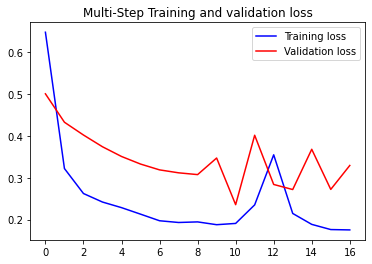

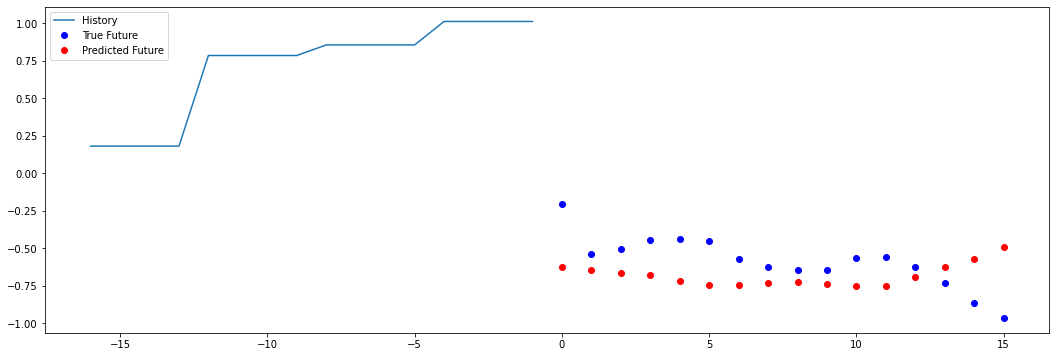

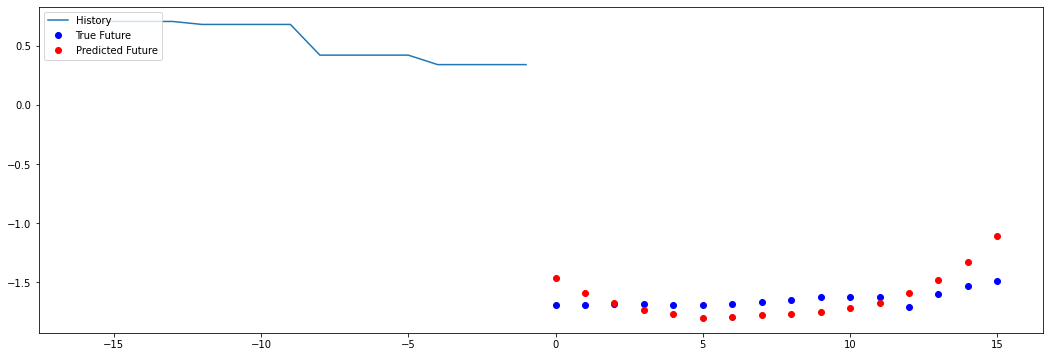

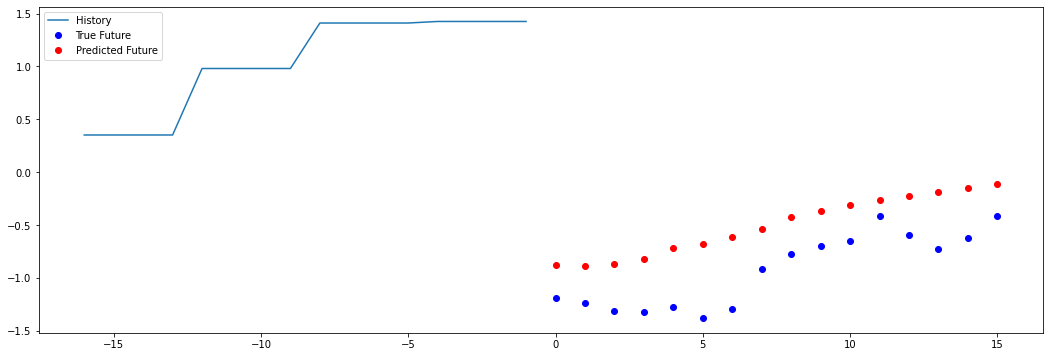

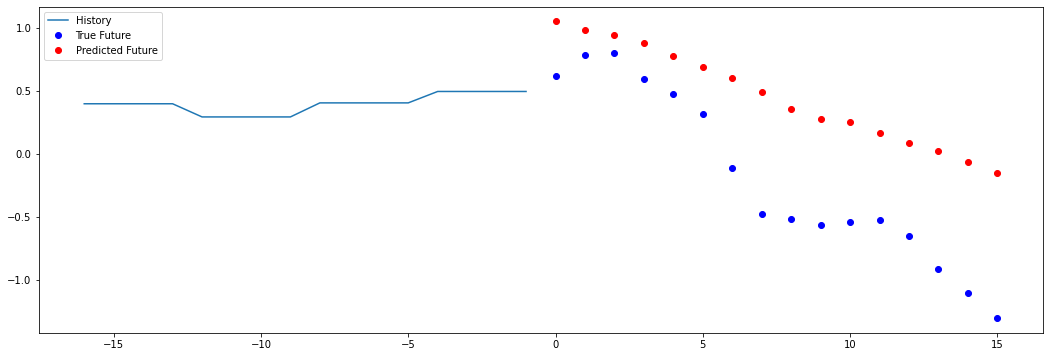

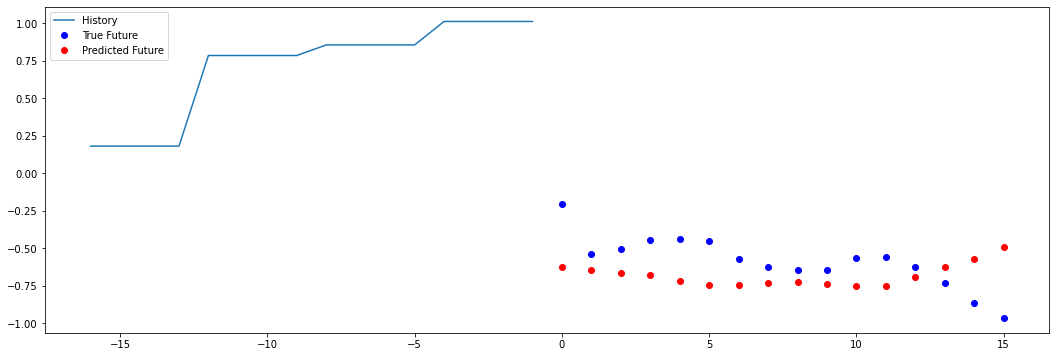

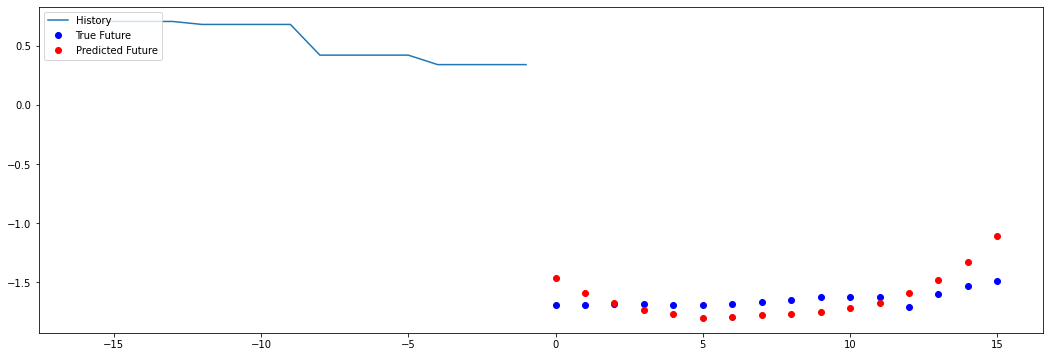

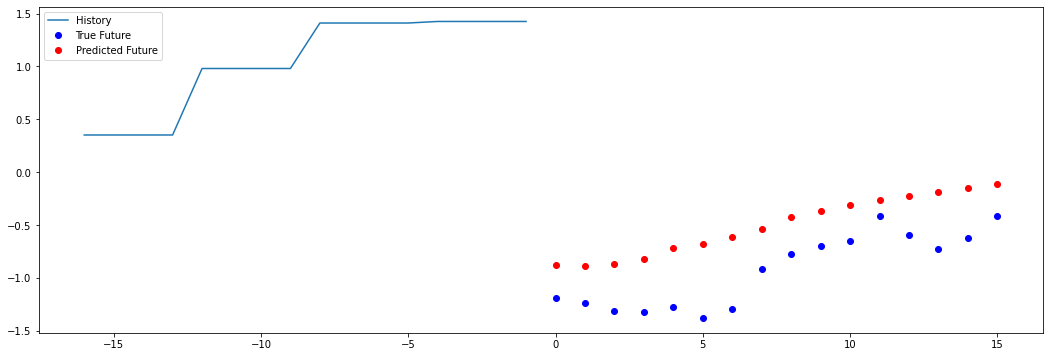

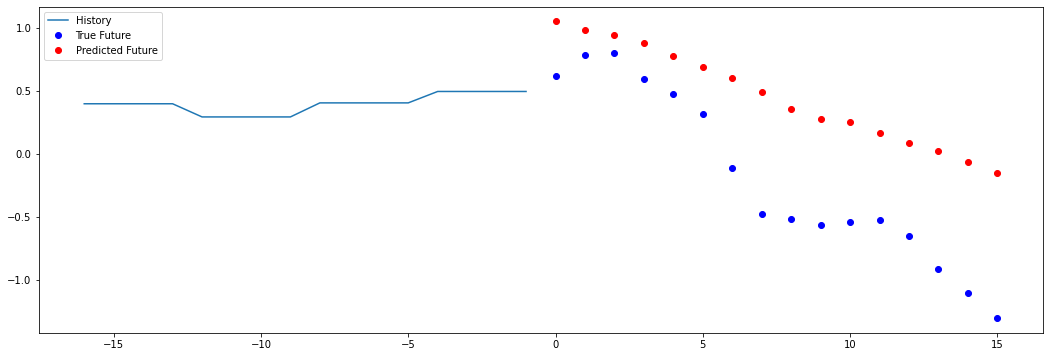

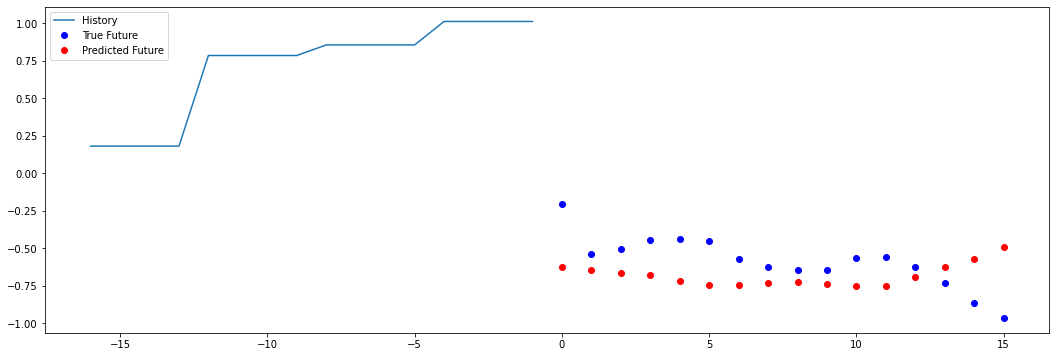

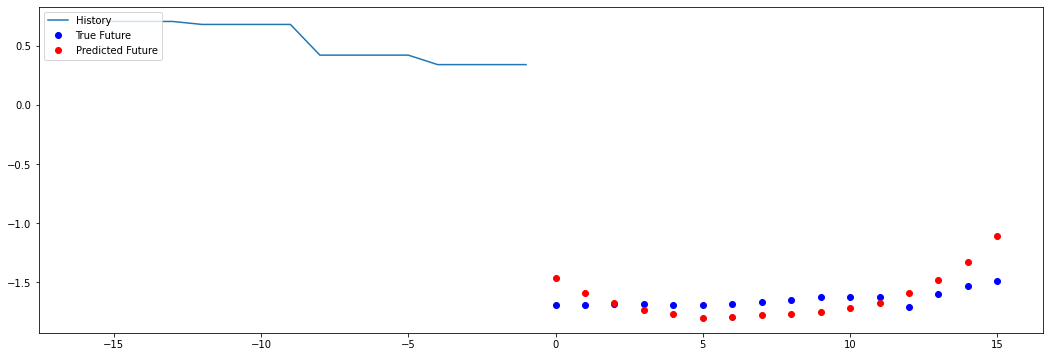

In [29]:
validation_plots(history,10,val_data,model,STEP)